<a href="https://colab.research.google.com/github/fatemehm/Federated-Learning-IDS/blob/main/ECU_ICU_Fed_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
client1 = pd.read_csv('/content/drive/MyDrive/GlobeCom/client_df1.csv')
client1_shuffled = client1.sample(frac=1, random_state = 13).reset_index(drop = True)

client2 = pd.read_csv('/content/drive/MyDrive/GlobeCom/client_df2.csv')
client2_shuffled = client2.sample(frac=1, random_state = 13).reset_index(drop = True)

client3 = pd.read_csv('/content/drive/MyDrive/GlobeCom/client_df3.csv')
client3_shuffled = client3.sample(frac=1, random_state = 13).reset_index(drop = True)

client4 = pd.read_csv('/content/drive/MyDrive/GlobeCom/client_df4.csv')
client4_shuffled = client4.sample(frac=1, random_state = 13).reset_index(drop = True)

client5 = pd.read_csv('/content/drive/MyDrive/GlobeCom/client_df5.csv')
client5_shuffled = client5.sample(frac=1, random_state = 13).reset_index(drop = True)

In [ ]:
EPOCHS = 50
BATCH_SIZE = 1024
#BATCH_SIZE = 64 #ECU

In [ ]:
from sklearn.preprocessing import LabelEncoder

def make_tf_dataset(dataframe, negative_ratio=None, batch_size=None):
  
    dataset = dataframe.drop(['Unnamed: 0'], axis=1)#, 'SrcGap', 'DstGap', 'DIntPktAct','sMinPktSz', 'Trans'
    # Class balancing
    pos_df = dataset[dataset['Label'] == 1]
    neg_df = dataset[dataset['Label'] == 0]
    if negative_ratio:
        neg_df = neg_df.iloc[random.sample(range(0, len(neg_df)), len(pos_df)*negative_ratio), :]
    balanced_df = pd.concat([pos_df, neg_df], ignore_index=True, sort=False)

    y = balanced_df.pop('Label')

    dataset = tf.data.Dataset.from_tensor_slices((balanced_df.values, y.to_frame().values))
    dataset = dataset.shuffle(4048, seed=SEED) #2048
    if batch_size:
        dataset = dataset.batch(batch_size)

    return dataset

In [ ]:
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
train_data, val_data = [], []

for client_data in [client1_shuffled, client2_shuffled, client3_shuffled, client4_shuffled, client5_shuffled]:
                     
                   
    train_df, val_df = train_test_split(client_data, test_size=0.1, random_state=1337)

    # Scaling (Standardization actually hurts performance) 
    encoder = LabelEncoder()
    scaler = StandardScaler() 
    train_features = scaler.fit_transform(train_df.drop(['Label'], axis=1))
    val_features = scaler.transform(val_df.drop(['Label'], axis=1))

    train_df[train_df.columns.difference(['Label'])] = train_features
    val_df[val_df.columns.difference(['Label'])] = val_features

    # TF Datasets
    train_data.append(make_tf_dataset(train_df,negative_ratio=2, batch_size=BATCH_SIZE)) #negative_ratio=2
    val_data.append(make_tf_dataset(val_df, batch_size=16))

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, BinaryAccuracy
def input_spec():
    return (
        tf.TensorSpec([None, 35], tf.float64),
        tf.TensorSpec([None, 1], tf.int64)
    )

def model_fn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(35,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    return tff.learning.from_keras_model(
        model,
        input_spec=input_spec(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy(), Precision(), Recall()]
        )

In [ ]:
trainer = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.05)#learning_rate=0.01
)

In [ ]:
str(trainer.initialize.type_signature)

'( -> <model=<trainable=<float32[35,32],float32[32],float32[32,64],float32[64],float32[64,32],float32[32],float32[32,1],float32[1]>,non_trainable=<>>,optimizer_state=<int64,float32[35,32],float32[32],float32[32,64],float32[64],float32[64,32],float32[32],float32[32,1],float32[1],float32[35,32],float32[32],float32[32,64],float32[64],float32[64,32],float32[32],float32[32,1],float32[1]>,delta_aggregate_state=<value_sum_process=<>,weight_sum_process=<>>,model_broadcast_state=<>>@SERVER)'

In [ ]:
state = trainer.initialize()

In [ ]:
import time
start = time.time()
start_time = time.time()
end = time.time()
diff=end-start
starttest = time.time()  
endtest =time.time()
difftest = endtest-starttest
#state = trainer.initialize()
train_hist = []
for i in range(EPOCHS):
    state, metrics = trainer.next(state, train_data)
    train_hist.append(metrics)

    print(f"\rRun {i+1}/{EPOCHS}", end="")
endtest =time.time()
#difftest = endtest-starttest
print("Training time: " + str(diff))
print("Test time: " + str(difftest))
time_required = time.time() - start_time
print('\nTIME: {}seconds'.format(time_required))

Run 50/50Training time: 3.2901763916015625e-05
Test time: 1.4543533325195312e-05

TIME: 97.76304984092712seconds


In [ ]:
print(metrics)

In [ ]:
train_hist

In [ ]:
federated_metrics = evaluator(state.model, val_data)
federated_metrics

OrderedDict([('eval',
              OrderedDict([('binary_accuracy', 0.9223242),
                           ('precision', 0.7183908),
                           ('recall', 0.61576355),
                           ('loss', 0.257914),
                           ('num_examples', 1635),
                           ('num_batches', 105)]))])

**Centralized-wus**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline

In [ ]:
df_uni = pd.read_csv('/content/drive/MyDrive/GlobeCom/clean_wustl.csv')
shape = df_uni.shape
print('Dataframe shape: ', shape)
print('Number of rows: ', shape[0])
print('Number of columns: ', shape[1])

Dataframe shape:  (16315, 37)
Number of rows:  16315
Number of columns:  37


In [ ]:
df_uni.Label.value_counts()

0    14269
1     2046
Name: Label, dtype: int64

In [ ]:
drop_columns = ['Unnamed: 0']#, 'Flgs','SrcAddr',	'DstAddr', 'Dport', 'SrcMac',	'DstMac',	'Packet_num']		
df_uni= df_uni.drop(columns=drop_columns)
df_uni.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16315 entries, 0 to 16314
Data columns (total 36 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sport       16315 non-null  float64
 1   SrcBytes    16315 non-null  float64
 2   DstBytes    16315 non-null  float64
 3   SrcLoad     16315 non-null  float64
 4   DstLoad     16315 non-null  float64
 5   SrcGap      16315 non-null  float64
 6   DstGap      16315 non-null  float64
 7   SIntPkt     16315 non-null  float64
 8   DIntPkt     16315 non-null  float64
 9   SIntPktAct  16315 non-null  float64
 10  DIntPktAct  16315 non-null  float64
 11  SrcJitter   16315 non-null  float64
 12  DstJitter   16315 non-null  float64
 13  sMaxPktSz   16315 non-null  float64
 14  dMaxPktSz   16315 non-null  float64
 15  sMinPktSz   16315 non-null  float64
 16  dMinPktSz   16315 non-null  float64
 17  Dur         16315 non-null  float64
 18  Trans       16315 non-null  float64
 19  TotPkts     16315 non-nul

In [ ]:
X_uni = df_uni.drop('Label', axis = 1)
y_uni = df_uni['Label']
X_uni.shape, y_uni.shape

((16315, 35), (16315,))

In [ ]:
from imblearn.over_sampling import SMOTE
X_uni_smote, y_uni_smote = SMOTE().fit_resample(X_uni, y_uni)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
#from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split
X_uni_train, X_uni_test, y_uni_train, y_uni_test = train_test_split(X_uni_smote, y_uni_smote, test_size=0.2, random_state = 1337)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaling = StandardScaler()
X_uni_train = scaling.fit_transform(X_uni_train)
X_uni_test = scaling.transform(X_uni_test)

In [ ]:
#For CNN and CNN-LSTM
X_uni_train = X_uni_train.reshape(X_uni_train.shape[0], X_uni_train.shape[1], 1)
X_uni_test = X_uni_test.reshape(X_uni_test.shape[0], X_uni_test.shape[1], 1)

**LSTM**

In [ ]:
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers import Dense, Dropout, Activation, Embedding
from tensorflow.keras import Sequential
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import numpy as np
import time
import time
start = time.time()
#from keras.optimizers import SGD
#opt = SGD(lr=0.0001)
#batch_size = 64

# 1. define the network
model = Sequential()
model.add(LSTM(4,input_shape = X_uni_train[0].shape))  
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.1), loss='binary_crossentropy', metrics=['accuracy'])
   
model.fit(X_uni_train, y_uni_train, epochs=50, batch_size = 20, validation_data=(X_uni_test, y_uni_test), verbose=1)
    
print(model.evaluate(X_uni_test, y_uni_test))
    
y_preds_cnn = model.predict(X_uni_test)
y_preds_cnn = np.round(y_preds_cnn)
    

    #y_preds_cnn = model.predict(X_test)
    #y_preds_cnn = np.round(y_preds_cnn)
cm = confusion_matrix(y_uni_test, y_preds_cnn)
print(confusion_matrix(y_uni_test, y_preds_cnn))
print(accuracy_score(y_uni_test, y_preds_cnn))
print("Classification Report: \n", classification_report(y_uni_test, y_preds_cnn))

start = time.time()
start_time = time.time()
end = time.time()
diff=end-start
starttest = time.time()  
endtest =time.time()
difftest = endtest-starttest

endtest =time.time()
#difftest = endtest-starttest
print("Training time: " + str(diff))
print("Test time: " + str(difftest))
time_required = time.time() - start_time
print('\nTIME: {}seconds'.format(time_required))



Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1142/1142 [==============================] - 22s 16ms/step - loss: 0.6852 - accuracy: 0.5409 - val_loss: 0.6078 - val_accuracy: 0.6780
Epoch 2/50
1142/1142 [==============================] - 16s 14ms/step - loss: 0.6822 - accuracy: 0.5523 - val_loss: 0.6614 - val_accuracy: 0.6137
Epoch 3/50
1142/1142 [==============================] - 16s 14ms/step - loss: 0.6599 - accuracy: 0.5845 - val_loss: 0.6734 - val_accuracy: 0.6163
Epoch 4/50
1142/1142 [==============================] - 17s 15ms/step - loss: 0.6431 - accuracy: 0.6009 - val_loss: 0.5997 - val_accuracy: 0.7102
Epoch 5/50
1142/1142 [==============================] - 16s 14ms/step - loss: 0.6845 - accuracy: 0.5498 - val_loss: 0.6924 - val_accuracy: 0.5205
Epoch 6/50
1142/1142 [==============================] - 16s 14ms/step - loss: 0.6993 - accuracy: 0.5053 - val_loss: 0.6954 - val_accuracy: 0.4788
Epoch 7/50
1142/1142 [==============================] - 17s 15ms/step - loss: 0.6880 - accuracy: 0.5330 - val_loss: 0.6937 - val_accura

**DNN**

In [ ]:
#from keras.layers import LSTM, SimpleRNN, GRU
#from keras.layers import Dense, Dropout, Activation, Embedding
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time
start = time.time()


# 1. define the network
model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(35,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(lr=0.1), loss='binary_crossentropy', metrics=['accuracy'])
   
model.fit(X_uni_train, y_uni_train, epochs=50, batch_size = 20, validation_data=(X_uni_test, y_uni_test), verbose=1)
    
print(model.evaluate(X_uni_test, y_uni_test))
    
y_preds_cnn = model.predict(X_uni_test)
y_preds_cnn = np.round(y_preds_cnn)
    

    #y_preds_cnn = model.predict(X_test)
    #y_preds_cnn = np.round(y_preds_cnn)
cm = confusion_matrix(y_uni_test, y_preds_cnn)
print(confusion_matrix(y_uni_test, y_preds_cnn))
print(accuracy_score(y_uni_test, y_preds_cnn))
print("Classification Report: \n", classification_report(y_uni_test, y_preds_cnn))


start = time.time()
start_time = time.time()
end = time.time()
diff=end-start
starttest = time.time()  
endtest =time.time()
difftest = endtest-starttest

endtest =time.time()
#difftest = endtest-starttest
print("Training time: " + str(diff))
print("Test time: " + str(difftest))
time_required = time.time() - start_time
print('\nTIME: {}seconds'.format(time_required))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
1142/1142 [==============================] - 3s 2ms/step - loss: 0.6669 - accuracy: 0.5853 - val_loss: 0.6960 - val_accuracy: 0.5040
Epoch 2/50
1142/1142 [==============================] - 2s 2ms/step - loss: 0.6963 - accuracy: 0.5022 - val_loss: 0.6937 - val_accuracy: 0.4960
Epoch 3/50
1142/1142 [==============================] - 2s 2ms/step - loss: 0.6961 - accuracy: 0.5023 - val_loss: 0.7028 - val_accuracy: 0.4960
Epoch 4/50
1142/1142 [==============================] - 2s 2ms/step - loss: 0.6954 - accuracy: 0.5038 - val_loss: 0.7013 - val_accuracy: 0.5040
Epoch 5/50
1142/1142 [==============================] - 2s 2ms/step - loss: 0.6961 - accuracy: 0.4957 - val_loss: 0.6968 - val_accuracy: 0.5040
Epoch 6/50
1142/1142 [==============================] - 3s 2ms/step - loss: 0.6958 - accuracy: 0.5004 - val_loss: 0.7043 - val_accuracy: 0.4960
Epoch 7/50
1142/1142 [==============================] - 2s 2ms/step - loss: 0.6959 - accuracy: 0.5023 - val_loss: 0.6938 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**CNN-LSTM**

In [ ]:
###############LSTM###################################
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers import Dense, Dropout, Activation, Embedding
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np

import time

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda

from sklearn.preprocessing import Normalizer
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D

from keras.layers import LSTM, GRU, SimpleRNN

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf

import seaborn as sns



lstm_output_size = 20
epochs = 10
model = Sequential()
model.add(Conv1D(32, 2, activation='relu', input_shape = X_uni_train[0].shape))

model.add(SimpleRNN(lstm_output_size))
model.add(Dropout(0.2))


model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.1), loss='binary_crossentropy', metrics=['accuracy'])
   
model.fit(X_uni_train, y_uni_train, epochs=50, batch_size = 20, validation_data=(X_uni_test, y_uni_test), verbose=1)
    
print(model.evaluate(X_uni_test, y_uni_test))
    
y_preds_cnn = model.predict(X_uni_test)
y_preds_cnn = np.round(y_preds_cnn)
    

    #y_preds_cnn = model.predict(X_test)
    #y_preds_cnn = np.round(y_preds_cnn)
cm = confusion_matrix(y_uni_test, y_preds_cnn)
print(confusion_matrix(y_uni_test, y_preds_cnn))
print(accuracy_score(y_uni_test, y_preds_cnn))
print("Classification Report: \n", classification_report(y_uni_test, y_preds_cnn))



start = time.time()
start_time = time.time()
end = time.time()
diff=end-start
starttest = time.time()  
endtest =time.time()
difftest = endtest-starttest

endtest =time.time()
#difftest = endtest-starttest
print("Training time: " + str(diff))
print("Test time: " + str(difftest))
time_required = time.time() - start_time
print('\nTIME: {}seconds'.format(time_required))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
1142/1142 [==============================] - 11s 9ms/step - loss: 0.7433 - accuracy: 0.4990 - val_loss: 0.7134 - val_accuracy: 0.4960
Epoch 2/50
1142/1142 [==============================] - 10s 9ms/step - loss: 0.7454 - accuracy: 0.5013 - val_loss: 0.7065 - val_accuracy: 0.4960
Epoch 3/50
1142/1142 [==============================] - 10s 9ms/step - loss: 0.7409 - accuracy: 0.5033 - val_loss: 0.8172 - val_accuracy: 0.4960
Epoch 4/50
1142/1142 [==============================] - 10s 9ms/step - loss: 0.7439 - accuracy: 0.4970 - val_loss: 0.7144 - val_accuracy: 0.4960
Epoch 5/50
1142/1142 [==============================] - 10s 9ms/step - loss: 0.7468 - accuracy: 0.4989 - val_loss: 0.6959 - val_accuracy: 0.5040
Epoch 6/50
1142/1142 [==============================] - 10s 9ms/step - loss: 0.7459 - accuracy: 0.4987 - val_loss: 0.7066 - val_accuracy: 0.4960
Epoch 7/50
1142/1142 [==============================] - 11s 9ms/step - loss: 0.7487 - accuracy: 0.4982 - val_loss: 0.8688 - val_ac

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **ECU-FEDERATED**

In [ ]:
!pip install --upgrade tensorflow-federated

     |████████████████████████████████| 819 kB 5.0 MB/s 
     |████████████████████████████████| 237 kB 42.3 MB/s 
     |████████████████████████████████| 45 kB 3.1 MB/s 
     |████████████████████████████████| 53 kB 1.2 MB/s 
     |████████████████████████████████| 65.1 MB 77 kB/s 
     |████████████████████████████████| 251 kB 39.9 MB/s 
     |████████████████████████████████| 121 kB 45.5 MB/s 
     |████████████████████████████████| 4.0 MB 30.4 MB/s 
     |████████████████████████████████| 887 kB 29.0 MB/s 
     |████████████████████████████████| 462 kB 51.3 MB/s 
     |████████████████████████████████| 4.2 MB 22.9 MB/s 
  Created wheel for jax: filename=jax-0.2.28-py3-none-any.whl size=1028669 sha256=c1092c4507823b155fa31ed2f4d1f24fa9b12ac3cd1da7e92e2167d90b93ac6e
  Stored in directory: /root/.cache/pip/wheels/e2/60/4c/0cf931b766116b73950d9b6fca5813a45789d45d412a8d7272
Successfully built jax
  Attempting uninstall: cachetools
    Found existing installation: cachetools 4.2.4
    Un

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.8.0


In [ ]:
import tensorflow_federated as tff 
print(tff.federated_computation(lambda: 'Hello World'))

In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
import collections

import numpy as np

#import tensorflow_federated as tff

#np.random.seed(0)
SEED = 1337
#tf.random.set_seed(SEED)

In [ ]:
import pandas as pd

In [ ]:
df_FL = pd.read_csv('/content/drive/MyDrive/GlobeCom/clean_ECU.csv')
df_ECU= df_FL.sample(frac=1, random_state = 13).reset_index(drop = True)

In [ ]:
df_FL.head()

,Unnamed: 0,Time,Source,Destination,Protocol,Length,Type,Type of attack
0,0,0.0,67.0,69.0,0.0,0.0,0,0.0
1,1,1.0,64.0,68.0,0.0,0.0,0,0.0
2,2,2.0,67.0,69.0,0.0,0.0,0,0.0
3,3,3.0,45.0,44.0,2.0,23.0,1,3.0
4,4,4.0,64.0,68.0,0.0,0.0,0,0.0


In [ ]:
df_FL.Type.value_counts()

0    87754
1    23453
Name: Type, dtype: int64

In [ ]:
for i, df in enumerate(np.array_split(df_ECU, 5)):
    df.to_csv('/content/drive/MyDrive/GlobeCom/'+f"client_ECU{i+1}.csv", index=False)

In [ ]:
df_FL.shape

(111207, 8)

In [ ]:
client1_ECU.Type.value_counts()

0    13145
1     9097
Name: Type, dtype: int64

In [ ]:
client2_ECU.Type.value_counts()

0    17518
1     4724
Name: Type, dtype: int64

In [ ]:
df_FL.head()

,Unnamed: 0,Time,Source,Destination,Protocol,Length,Type,Type of attack
0,0,0.0,67.0,69.0,0.0,0.0,0,0.0
1,1,1.0,64.0,68.0,0.0,0.0,0,0.0
2,2,2.0,67.0,69.0,0.0,0.0,0,0.0
3,3,3.0,45.0,44.0,2.0,23.0,1,3.0
4,4,4.0,64.0,68.0,0.0,0.0,0,0.0


In [ ]:
df_FL.Type.value_counts()

0    87754
1    23453
Name: Type, dtype: int64

In [ ]:
client1_ECU = pd.read_csv('/content/drive/MyDrive/ECU/client_ECU1.csv')
client1_ECU_shuffled = client1_ECU.sample(frac=1, random_state = 13).reset_index(drop = True)

client2_ECU = pd.read_csv('/content/drive/MyDrive/ECU/client_ECU2.csv')
client2_ECU_shuffled = client2_ECU.sample(frac=1, random_state = 13).reset_index(drop = True)

client3_ECU = pd.read_csv('/content/drive/MyDrive/ECU/client_ECU3.csv')
client3_ECU_shuffled = client3_ECU.sample(frac=1, random_state = 13).reset_index(drop = True)

client4_ECU = pd.read_csv('/content/drive/MyDrive/ECU/client_ECU4.csv')
client4_ECU_shuffled = client4_ECU.sample(frac=1, random_state = 13).reset_index(drop = True)

client5_ECU = pd.read_csv('/content/drive/MyDrive/ECU/client_ECU5.csv')
client5_ECU_shuffled = client5_ECU.sample(frac=1, random_state = 13).reset_index(drop = True)



In [ ]:
client3_ECU.Type.value_counts()

0    17645
1     4596
Name: Type, dtype: int64

In [ ]:
client1_ECU_shuffled.Type.value_counts()

0    17562
1     4680
Name: Type, dtype: int64

In [ ]:
EPOCHS = 50
#BATCH_SIZE = 512
BATCH_SIZE = 1024 #ECU

In [ ]:
from sklearn.preprocessing import LabelEncoder

def make_tf_dataset(dataframe, batch_size=None):
  
    dataset = dataframe.drop(['Unnamed: 0'], axis=1)
    count_FL_0, count_FL_1 = dataset.Type.value_counts()

    df_FL_0 = dataset[dataset['Type'] == 0]
    df_FL_1 = dataset[dataset['Type'] == 1]

    df_FL_0_under = df_FL_0.sample(count_FL_1)
    df_FL_under = pd.concat([df_FL_0_under, df_FL_1], axis = 0)
    y = df_FL_under.pop('Type')

    dataset = tf.data.Dataset.from_tensor_slices((df_FL_under.values, y.to_frame().values))
    dataset = dataset.shuffle(4048, seed=SEED) #2048
    if batch_size:
        dataset = dataset.batch(batch_size)

    return dataset

In [ ]:
#########################################ECU#######################################################
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
train_data, val_data = [], []

for client_data in [client1_ECU_shuffled, client2_ECU_shuffled, client3_ECU_shuffled, client4_ECU_shuffled, client5_ECU_shuffled]:
                     
                   
    train_df, val_df = train_test_split(client_data, test_size=0.2, random_state=1337)

    # Scaling (Standardization actually hurts performance) 
    #encoder = LabelEncoder()
    scaler = StandardScaler() 
    train_features = scaler.fit_transform(train_df.drop(['Type'], axis=1))
    val_features = scaler.transform(val_df.drop(['Type'], axis=1))
  
    #encoder = LabelEncoder()
    #y1 = encoder.fit_transform(y)
    #Y= pd.get_dummies(y1).values
    train_df[train_df.columns.difference(['Type'])] = train_features
    val_df[val_df.columns.difference(['Type'])] = val_features

    # TF Datasets
    train_data.append(make_tf_dataset(train_df, batch_size=BATCH_SIZE)) #negative_ratio=2
    val_data.append(make_tf_dataset(val_df, batch_size=16))

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, BinaryAccuracy
def input_spec():
    return (
        tf.TensorSpec([None, 6], tf.float64),
        tf.TensorSpec([None, 1], tf.int64)
    )

def model_fn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(6,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    return tff.learning.from_keras_model(
        model,
        input_spec=input_spec(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy(), Precision(), Recall()]
        )

In [ ]:
trainer = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.05)#learning_rate=0.01
)

In [ ]:
str(trainer.initialize.type_signature)

'( -> <model=<trainable=<float32[6,32],float32[32],float32[32,64],float32[64],float32[64,32],float32[32],float32[32,1],float32[1]>,non_trainable=<>>,optimizer_state=<int64,float32[6,32],float32[32],float32[32,64],float32[64],float32[64,32],float32[32],float32[32,1],float32[1],float32[6,32],float32[32],float32[32,64],float32[64],float32[64,32],float32[32],float32[32,1],float32[1]>,delta_aggregate_state=<value_sum_process=<>,weight_sum_process=<>>,model_broadcast_state=<>>@SERVER)'

In [ ]:
state = trainer.initialize()

In [ ]:

import time
start = time.time()
start_time = time.time()
end = time.time()
diff=end-start
starttest = time.time()  
endtest =time.time()
difftest = endtest-starttest
#state = trainer.initialize()
train_hist = []
for i in range(EPOCHS):
    state, metrics = trainer.next(state, train_data)
    train_hist.append(metrics)

    print(f"\rRun {i+1}/{EPOCHS}", end="")
endtest =time.time()
#difftest = endtest-starttest
print("Training time: " + str(diff))
print("Test time: " + str(difftest))
time_required = time.time() - start_time
print('\nTIME: {}seconds'.format(time_required))

Run 50/50Training time: 3.4809112548828125e-05
Test time: 1.430511474609375e-05

TIME: 97.74022579193115seconds


In [ ]:
print(metrics)

OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('binary_accuracy', 0.9927455), ('precision', 0.9877502), ('recall', 0.99786633), ('loss', 0.04286906), ('num_examples', 37494), ('num_batches', 40)]))])


In [ ]:
train_hist

[OrderedDict([('broadcast', ()),
              ('aggregation',
               OrderedDict([('mean_value', ()), ('mean_weight', ())])),
              ('train',
               OrderedDict([('binary_accuracy', 0.80956954),
                            ('precision', 0.8300631),
                            ('recall', 0.7785246),
                            ('loss', 0.4668336),
                            ('num_examples', 37494),
                            ('num_batches', 40)]))]),
 OrderedDict([('broadcast', ()),
              ('aggregation',
               OrderedDict([('mean_value', ()), ('mean_weight', ())])),
              ('train',
               OrderedDict([('binary_accuracy', 0.90841204),
                            ('precision', 0.91699797),
                            ('recall', 0.898117),
                            ('loss', 0.34919313),
                            ('num_examples', 37494),
                            ('num_batches', 40)]))]),
 OrderedDict([('broadcast', ()),
    

In [ ]:
evaluator = tff.learning.build_federated_evaluation(model_fn)

In [ ]:
federated_metrics = evaluator(state.model, val_data)
federated_metrics

OrderedDict([('eval',
              OrderedDict([('binary_accuracy', 0.9934127),
                           ('precision', 0.98720104),
                           ('recall', 0.9997875),
                           ('loss', 0.040167395),
                           ('num_examples', 9412),
                           ('num_batches', 590)]))])

# **Centralized ECU**

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df_FL1 = pd.read_csv('/content/drive/MyDrive/GlobeCom/clean_ECU.csv')


In [ ]:
df_FL1.head()

,Unnamed: 0,Time,Source,Destination,Protocol,Length,Type,Type of attack
0,0,0.0,67.0,69.0,0.0,0.0,0,0.0
1,1,1.0,64.0,68.0,0.0,0.0,0,0.0
2,2,2.0,67.0,69.0,0.0,0.0,0,0.0
3,3,3.0,45.0,44.0,2.0,23.0,1,3.0
4,4,4.0,64.0,68.0,0.0,0.0,0,0.0


In [ ]:
drop_columns = ['Unnamed: 0']#, 'Type of attack']		
df_FL= df_FL1.drop(columns=drop_columns)


In [ ]:
count_FL_0, count_FL_1 = df_FL.Type.value_counts()

In [ ]:
count_FL_0, count_FL_1 

(87754, 23453)

In [ ]:
df_FL_0 = df_FL[df_FL['Type'] == 0]
df_FL_1 = df_FL[df_FL['Type'] == 1]

In [ ]:
df_FL_0.shape

(87754, 7)

In [ ]:
df_FL_1.shape

(23453, 7)

In [ ]:
df_FL_0_under = df_FL_0.sample(count_FL_1)
df_FL_under = pd.concat([df_FL_0_under, df_FL_1], axis = 0)
print('Random under-sampling:')
print(df_FL_under.Type.value_counts())

Random under-sampling:
0    23453
1    23453
Name: Type, dtype: int64


In [ ]:
X = df_FL_under.drop('Type', axis = 'columns')
y = df_FL_under['Type']

In [ ]:
#X = df_FL.drop('Type', axis = 'columns')
#y= df_FL['Type']

In [ ]:
#from imblearn.over_sampling import SMOTE
#X_smote, y_smote = SMOTE().fit_resample(X, y)

In [ ]:
#from sklearn.preprocessing import LabelEncoder
#encoder = LabelEncoder()
#y1 = encoder.fit_transform(y)
#Y= pd.get_dummies(y1).values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X , y, test_size = 0.2, random_state = 1337)#, stratify = Y)'''

In [ ]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split( X_smote , y_smote, test_size = 0.1, random_state = 1337)#, stratify = Y)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaling = StandardScaler()
X_train = scaling.fit_transform(X_train)
X_test = scaling.transform(X_test)

In [ ]:
#For CNN and CNN-LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

**CNN**

In [ ]:
###############LSTM###################################
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers import Dense, Dropout, Activation, Embedding
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np

import time

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda

from sklearn.preprocessing import Normalizer
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D

from keras.layers import LSTM, GRU, SimpleRNN

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf

import seaborn as sns

model = Sequential()
model.add(Conv1D(32, 2, activation='relu', input_shape = X_train[0].shape))

#model.add(SimpleRNN(lstm_output_size))
model.add(Dropout(0.2))


model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.1), loss='binary_crossentropy', metrics=['accuracy'])
   
model.fit(X_train, y_train, epochs=50, batch_size = 20, validation_data=(X_test, y_test), verbose=1)
    
print(model.evaluate(X_test, y_test))
    
y_preds_cnn = model.predict(X_test)
y_preds_cnn = np.round(y_preds_cnn)
    

    #y_preds_cnn = model.predict(X_test)
    #y_preds_cnn = np.round(y_preds_cnn)
cm = confusion_matrix(y_test, y_preds_cnn)
print(confusion_matrix(y_test, y_preds_cnn))
print(accuracy_score(y_test, y_preds_cnn))
print("Classification Report: \n", classification_report(y_test, y_preds_cnn))



start = time.time()
start_time = time.time()
end = time.time()
diff=end-start
starttest = time.time()  
endtest =time.time()
difftest = endtest-starttest

endtest =time.time()
#difftest = endtest-starttest
print("Training time: " + str(diff))
print("Test time: " + str(difftest))
time_required = time.time() - start_time
print('\nTIME: {}seconds'.format(time_required))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1877/1877 [==============================] - 4s 2ms/step - loss: 0.5761 - accuracy: 0.7476 - val_loss: 0.5312 - val_accuracy: 0.7798
Epoch 2/50
1877/1877 [==============================] - 3s 2ms/step - loss: 0.5745 - accuracy: 0.7463 - val_loss: 0.5355 - val_accuracy: 0.7630
Epoch 3/50
1877/1877 [==============================] - 3s 2ms/step - loss: 0.5870 - accuracy: 0.7407 - val_loss: 0.5677 - val_accuracy: 0.7579
Epoch 4/50
1877/1877 [==============================] - 3s 1ms/step - loss: 0.5923 - accuracy: 0.7370 - val_loss: 0.5760 - val_accuracy: 0.6931
Epoch 5/50
1877/1877 [==============================] - 3s 1ms/step - loss: 0.5970 - accuracy: 0.7304 - val_loss: 0.5764 - val_accuracy: 0.7669
Epoch 6/50
1877/1877 [==============================] - 3s 1ms/step - loss: 0.6001 - accuracy: 0.7263 - val_loss: 0.5842 - val_accuracy: 0.7332
Epoch 7/50
1877/1877 [==============================] - 3s 2ms/step - loss: 0.6074 - accuracy: 0.7192 - val_loss: 0.5748 - val_accuracy: 0.7600
Epo

**LSTM**

In [ ]:
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers import Dense, Dropout, Activation, Embedding
from tensorflow.keras import Sequential
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import numpy as np
import time
import time
start = time.time()
#from keras.optimizers import SGD
#opt = SGD(lr=0.0001)
#batch_size = 64

# 1. define the network
model = Sequential()
model.add(LSTM(4,input_shape = X_train[0].shape))  
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.1), loss='binary_crossentropy', metrics=['accuracy'])
   
model.fit(X_train, y_train, epochs=50, batch_size = 20, validation_data=(X_test, y_test), verbose=1)
    
print(model.evaluate(X_test, y_test))
    
y_preds_cnn = model.predict(X_test)
y_preds_cnn = np.round(y_preds_cnn)
    

    #y_preds_cnn = model.predict(X_test)
    #y_preds_cnn = np.round(y_preds_cnn)
cm = confusion_matrix(y_test, y_preds_cnn)
print(confusion_matrix(y_test, y_preds_cnn))
print(accuracy_score(y_test, y_preds_cnn))
print("Classification Report: \n", classification_report(y_test, y_preds_cnn))

start = time.time()
start_time = time.time()
end = time.time()
diff=end-start
starttest = time.time()  
endtest =time.time()
difftest = endtest-starttest

endtest =time.time()
#difftest = endtest-starttest
print("Training time: " + str(diff))
print("Test time: " + str(difftest))
time_required = time.time() - start_time
print('\nTIME: {}seconds'.format(time_required))





Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1877/1877 [==============================] - 10s 4ms/step - loss: 0.2250 - accuracy: 0.9135 - val_loss: 0.1344 - val_accuracy: 0.9565
Epoch 2/50
1877/1877 [==============================] - 7s 4ms/step - loss: 0.1960 - accuracy: 0.9252 - val_loss: 0.1501 - val_accuracy: 0.9529
Epoch 3/50
1877/1877 [==============================] - 7s 4ms/step - loss: 0.1949 - accuracy: 0.9269 - val_loss: 0.1055 - val_accuracy: 0.9731
Epoch 4/50
1877/1877 [==============================] - 9s 5ms/step - loss: 0.1557 - accuracy: 0.9252 - val_loss: 0.0926 - val_accuracy: 0.9565
Epoch 5/50
1877/1877 [==============================] - 7s 4ms/step - loss: 0.1507 - accuracy: 0.9220 - val_loss: 0.0718 - val_accuracy: 0.9858
Epoch 6/50
1877/1877 [==============================] - 6s 3ms/step - loss: 0.1738 - accuracy: 0.9169 - val_loss: 0.0789 - val_accuracy: 0.9553
Epoch 7/50
1877/1877 [==============================] - 7s 4ms/step - loss: 0.1488 - accuracy: 0.9264 - val_loss: 0.0842 - val_accuracy: 0.9565
Ep

**DNN**

In [ ]:
#from keras.layers import LSTM, SimpleRNN, GRU
#from keras.layers import Dense, Dropout, Activation, Embedding
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time
start = time.time()


# 1. define the network
model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(6,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(lr=0.1), loss='binary_crossentropy', metrics=['accuracy'])
   
model.fit(X_train, y_train, epochs=50, batch_size = 20, validation_data=(X_test, y_test), verbose=1)
    
print(model.evaluate(X_test, y_test))
    
y_preds_cnn = model.predict(X_test)
y_preds_cnn = np.round(y_preds_cnn)
    

    #y_preds_cnn = model.predict(X_test)
    #y_preds_cnn = np.round(y_preds_cnn)
cm = confusion_matrix(y_test, y_preds_cnn)
print(confusion_matrix(y_test, y_preds_cnn))
print(accuracy_score(y_test, y_preds_cnn))
print("Classification Report: \n", classification_report(y_test, y_preds_cnn))


start = time.time()
start_time = time.time()
end = time.time()
diff=end-start
starttest = time.time()  
endtest =time.time()
difftest = endtest-starttest

endtest =time.time()
#difftest = endtest-starttest
print("Training time: " + str(diff))
print("Test time: " + str(difftest))
time_required = time.time() - start_time
print('\nTIME: {}seconds'.format(time_required))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1877/1877 [==============================] - 8s 3ms/step - loss: 0.2229 - accuracy: 0.9926 - val_loss: 0.0042 - val_accuracy: 0.9993
Epoch 2/50
1877/1877 [==============================] - 5s 3ms/step - loss: 0.0949 - accuracy: 0.9801 - val_loss: 0.1464 - val_accuracy: 0.9456
Epoch 3/50
1877/1877 [==============================] - 4s 2ms/step - loss: 0.1138 - accuracy: 0.9432 - val_loss: 0.1115 - val_accuracy: 0.9456
Epoch 4/50
1877/1877 [==============================] - 4s 2ms/step - loss: 0.1063 - accuracy: 0.9432 - val_loss: 0.1051 - val_accuracy: 0.9456
Epoch 5/50
1877/1877 [==============================] - 4s 2ms/step - loss: 0.1062 - accuracy: 0.9429 - val_loss: 0.1080 - val_accuracy: 0.9456
Epoch 6/50
1877/1877 [==============================] - 4s 2ms/step - loss: 0.1065 - accuracy: 0.9432 - val_loss: 0.1060 - val_accuracy: 0.9456
Epoch 7/50
1877/1877 [==============================] - 4s 2ms/step - loss: 0.1066 - accuracy: 0.9432 - val_loss: 0.1072 - val_accuracy: 0.9456
Epo

**CNN-LSTM**

In [ ]:
###############LSTM###################################
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers import Dense, Dropout, Activation, Embedding
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np

import time

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda

from sklearn.preprocessing import Normalizer
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D

from keras.layers import LSTM, GRU, SimpleRNN

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf

import seaborn as sns



lstm_output_size = 20
epochs = 10
model = Sequential()
model.add(Conv1D(32, 2, activation='relu', input_shape = X_train[0].shape))

model.add(SimpleRNN(lstm_output_size))
model.add(Dropout(0.2))


model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.1), loss='binary_crossentropy', metrics=['accuracy'])
   
model.fit(X_train, y_train, epochs=50, batch_size = 20, validation_data=(X_test, y_test), verbose=1)
    
print(model.evaluate(X_test, y_test))
    
y_preds_cnn = model.predict(X_test)
y_preds_cnn = np.round(y_preds_cnn)
    

    #y_preds_cnn = model.predict(X_test)
    #y_preds_cnn = np.round(y_preds_cnn)
cm = confusion_matrix(y_test, y_preds_cnn)
print(confusion_matrix(y_test, y_preds_cnn))
print(accuracy_score(y_test, y_preds_cnn))
print("Classification Report: \n", classification_report(y_test, y_preds_cnn))



start = time.time()
start_time = time.time()
end = time.time()
diff=end-start
starttest = time.time()  
endtest =time.time()
difftest = endtest-starttest

endtest =time.time()
#difftest = endtest-starttest
print("Training time: " + str(diff))
print("Test time: " + str(difftest))
time_required = time.time() - start_time
print('\nTIME: {}seconds'.format(time_required))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1877/1877 [==============================] - 7s 3ms/step - loss: 0.2169 - accuracy: 0.9323 - val_loss: 0.1699 - val_accuracy: 0.9302
Epoch 2/50
1877/1877 [==============================] - 5s 3ms/step - loss: 0.2227 - accuracy: 0.9317 - val_loss: 0.2153 - val_accuracy: 0.9294
Epoch 3/50
1877/1877 [==============================] - 6s 3ms/step - loss: 0.2366 - accuracy: 0.9244 - val_loss: 0.1837 - val_accuracy: 0.9444
Epoch 4/50
1877/1877 [==============================] - 5s 3ms/step - loss: 0.2314 - accuracy: 0.9238 - val_loss: 0.2053 - val_accuracy: 0.9441
Epoch 5/50
1877/1877 [==============================] - 5s 3ms/step - loss: 0.2299 - accuracy: 0.9271 - val_loss: 0.1754 - val_accuracy: 0.9448
Epoch 6/50
1877/1877 [==============================] - 5s 3ms/step - loss: 0.2399 - accuracy: 0.9239 - val_loss: 0.2157 - val_accuracy: 0.9444
Epoch 7/50
1877/1877 [==============================] - 5s 3ms/step - loss: 0.2332 - accuracy: 0.9267 - val_loss: 0.1764 - val_accuracy: 0.9443
Epo

# **ICU-Federated**

In [ ]:
import numpy as np  
import pandas as pd
import os 
from sklearn.model_selection import train_test_split

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/ICU/environmentMonitoring.csv')
df1.columns

Index(['frame.time_delta', 'frame.time_relative', 'frame.len', 'ip.src',
       'ip.dst', 'tcp.srcport', 'tcp.dstport', 'tcp.flags', 'tcp.time_delta',
       'tcp.len', 'tcp.ack', 'tcp.connection.fin', 'tcp.connection.rst',
       'tcp.connection.sack', 'tcp.connection.syn', 'tcp.flags.ack',
       'tcp.flags.fin', 'tcp.flags.push', 'tcp.flags.reset', 'tcp.flags.syn',
       'tcp.flags.urg', 'tcp.hdr_len', 'tcp.payload', 'tcp.pdu.size',
       'tcp.window_size_value', 'tcp.checksum', 'mqtt.clientid',
       'mqtt.clientid_len', 'mqtt.conack.flags', 'mqtt.conack.val',
       'mqtt.conflag.passwd', 'mqtt.conflag.qos', 'mqtt.conflag.reserved',
       'mqtt.conflag.retain', 'mqtt.conflag.willflag', 'mqtt.conflags',
       'mqtt.dupflag', 'mqtt.hdrflags', 'mqtt.kalive', 'mqtt.len', 'mqtt.msg',
       'mqtt.msgtype', 'mqtt.qos', 'mqtt.retain', 'mqtt.topic',
       'mqtt.topic_len', 'mqtt.ver', 'mqtt.willmsg_len', 'ip.proto', 'ip.ttl',
       'class', 'label'],
      dtype='object')

In [ ]:
import os
path = '/content/drive/MyDrive/ICU/'
csvs = os.listdir(path)
csvs

['environmentMonitoring.csv', 'Attack.csv']

In [ ]:
df1 = pd.DataFrame()

for csv in csvs:
  print(f'---- Reading {csv} ----')
  df = pd.read_csv(path+csv)
  print(f'df.shape: {df.shape}')
  empty_cols = [col for col in df.columns if df[col].isnull().all()]
  print(f'empty_cols: {len(empty_cols)}')
  print(empty_cols)
  df.fillna(0, inplace=True)
  df1 = df1.append(df, ignore_index=True)
  print(f'df1.shape: {df1.shape}')

---- Reading environmentMonitoring.csv ----
df.shape: (31758, 52)
empty_cols: 0
[]
df1.shape: (31758, 52)
---- Reading Attack.csv ----
df.shape: (80126, 52)
empty_cols: 0
[]
df1.shape: (111884, 52)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (26,28,35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
feats = ['ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport','mqtt.topic', 'mqtt.msg', 'tcp.payload','mqtt.clientid', 'mqtt.conflags', 'mqtt.conack.flags', 'class']

In [ ]:
df1.drop(labels=feats, axis=1, inplace=True)
df1.shape

(111884, 41)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111884 entries, 0 to 111883
Data columns (total 41 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   frame.time_delta       111884 non-null  float64
 1   frame.time_relative    111884 non-null  float64
 2   frame.len              111884 non-null  int64  
 3   tcp.flags              111884 non-null  object 
 4   tcp.time_delta         111884 non-null  float64
 5   tcp.len                111884 non-null  int64  
 6   tcp.ack                111884 non-null  int64  
 7   tcp.connection.fin     111884 non-null  float64
 8   tcp.connection.rst     111884 non-null  float64
 9   tcp.connection.sack    111884 non-null  float64
 10  tcp.connection.syn     111884 non-null  float64
 11  tcp.flags.ack          111884 non-null  int64  
 12  tcp.flags.fin          111884 non-null  int64  
 13  tcp.flags.push         111884 non-null  int64  
 14  tcp.flags.reset        111884 non-nu

In [ ]:
df1.head()

,frame.time_delta,frame.time_relative,frame.len,tcp.flags,tcp.time_delta,tcp.len,tcp.ack,tcp.connection.fin,tcp.connection.rst,tcp.connection.sack,tcp.connection.syn,tcp.flags.ack,tcp.flags.fin,tcp.flags.push,tcp.flags.reset,tcp.flags.syn,tcp.flags.urg,tcp.hdr_len,tcp.pdu.size,tcp.window_size_value,tcp.checksum,mqtt.clientid_len,mqtt.conack.val,mqtt.conflag.passwd,mqtt.conflag.qos,mqtt.conflag.reserved,mqtt.conflag.retain,mqtt.conflag.willflag,mqtt.dupflag,mqtt.hdrflags,mqtt.kalive,mqtt.len,mqtt.msgtype,mqtt.qos,mqtt.retain,mqtt.topic_len,mqtt.ver,mqtt.willmsg_len,ip.proto,ip.ttl,label
0,0.000000,0.000000,105,0x00000018,0.000000,37,1,0.0,0.0,0.0,0.0,1,0,1,0,0,0,32,37.0,512,0x00001141,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0x00000010,60.0,35.0,1.0,0.0,0.0,0.0,4.0,0.0,6,64,0
1,0.000053,0.000053,72,0x00000018,0.000053,4,38,0.0,0.0,0.0,0.0,1,0,1,0,0,0,32,4.0,512,0x00001120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0x00000020,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,6,64,0
2,0.000043,0.000096,105,0x00000018,0.000000,37,1,0.0,0.0,0.0,0.0,1,0,1,0,0,0,32,37.0,512,0x00001143,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0x00000010,60.0,35.0,1.0,0.0,0.0,0.0,4.0,0.0,6,64,0
3,0.000020,0.000116,72,0x00000018,0.000020,4,38,0.0,0.0,0.0,0.0,1,0,1,0,0,0,32,4.0,512,0x00001122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0x00000020,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,6,64,0
4,0.000016,0.000132,105,0x00000018,0.000000,37,1,0.0,0.0,0.0,0.0,1,0,1,0,0,0,32,37.0,512,0x00001145,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0x00000010,60.0,35.0,1.0,0.0,0.0,0.0,4.0,0.0,6,64,0


In [ ]:
df1.label.value_counts()

1    80126
0    31758
Name: label, dtype: int64

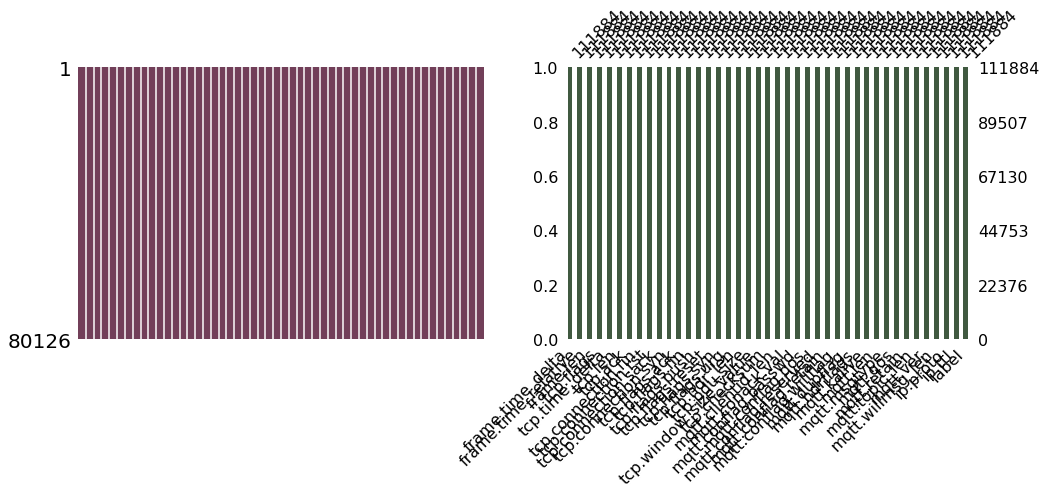

In [ ]:
import matplotlib.pyplot as plt
import missingno as msno
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
msno.matrix(df, ax=ax1, sparkline=False, color=(0.45, 0.25, 0.35))
msno.bar(df1, ax=ax2, color=(0.25, 0.35, 0.25))
plt.show()

In [ ]:
df1.isnull().sum()

frame.time_delta         0
frame.time_relative      0
frame.len                0
tcp.flags                0
tcp.time_delta           0
tcp.len                  0
tcp.ack                  0
tcp.connection.fin       0
tcp.connection.rst       0
tcp.connection.sack      0
tcp.connection.syn       0
tcp.flags.ack            0
tcp.flags.fin            0
tcp.flags.push           0
tcp.flags.reset          0
tcp.flags.syn            0
tcp.flags.urg            0
tcp.hdr_len              0
tcp.pdu.size             0
tcp.window_size_value    0
tcp.checksum             0
mqtt.clientid_len        0
mqtt.conack.val          0
mqtt.conflag.passwd      0
mqtt.conflag.qos         0
mqtt.conflag.reserved    0
mqtt.conflag.retain      0
mqtt.conflag.willflag    0
mqtt.dupflag             0
mqtt.hdrflags            0
mqtt.kalive              0
mqtt.len                 0
mqtt.msgtype             0
mqtt.qos                 0
mqtt.retain              0
mqtt.topic_len           0
mqtt.ver                 0
m

In [ ]:
df1[df1.duplicated()].shape

(2, 41)

In [ ]:

df1 = df1.drop(df1[df1.duplicated()].index)


In [ ]:
df1[df1.duplicated()].shape

(0, 41)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111882 entries, 0 to 111883
Data columns (total 41 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   frame.time_delta       111882 non-null  float64
 1   frame.time_relative    111882 non-null  float64
 2   frame.len              111882 non-null  int64  
 3   tcp.flags              111882 non-null  object 
 4   tcp.time_delta         111882 non-null  float64
 5   tcp.len                111882 non-null  int64  
 6   tcp.ack                111882 non-null  int64  
 7   tcp.connection.fin     111882 non-null  float64
 8   tcp.connection.rst     111882 non-null  float64
 9   tcp.connection.sack    111882 non-null  float64
 10  tcp.connection.syn     111882 non-null  float64
 11  tcp.flags.ack          111882 non-null  int64  
 12  tcp.flags.fin          111882 non-null  int64  
 13  tcp.flags.push         111882 non-null  int64  
 14  tcp.flags.reset        111882 non-nu

In [ ]:
col=['tcp.flags.ack', 'tcp.flags.fin']
#col = ['tcp.flags', 'tcp.checksum', 'mqtt.hdrflags', 'tcp.flags.ack', 'tcp.flags.fin']
df1 = df1.drop(columns=col)


In [ ]:
  
df1['frame.len'] = df1['frame.len'].astype(float)
#df1['tcp.flags'] = df1['tcp.flags'].astype(float)
df1['tcp.len'] = df1['tcp.len'].astype(float)
df1['tcp.ack'] = df1['tcp.ack'].astype(float)
df1['tcp.flags.ack '] = df1['tcp.flags.ack'].astype(float)
df1['tcp.flags.fin '] = df1['tcp.flags.fin'].astype(float)
df1['tcp.flags.push'] = df1['tcp.flags.push'].astype(float)
df1['tcp.flags.reset'] = df1['tcp.flags.reset'].astype(float)
df1['tcp.flags.syn'] = df1['tcp.flags.syn'].astype(float)
df1['tcp.flags.urg'] = df1['tcp.flags.urg'].astype(float)
df1['tcp.hdr_len'] = df1['tcp.hdr_len'].astype(float)
df1['tcp.window_size_value'] = df1['tcp.window_size_value'].astype(float)
#df1['tcp.checksum'] = df1['tcp.checksum'].astype(float)

#df1['mqtt.hdrflags'] = df1['mqtt.hdrflags'].astype(float)
df1['ip.proto'] = df1['ip.proto'].astype(float)
df1['ip.ttl'] = df1['ip.ttl'].astype(float)

df1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 111882 entries, 0 to 111883
Data columns (total 43 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   frame.time_delta       111882 non-null  float64
 1   frame.time_relative    111882 non-null  float64
 2   frame.len              111882 non-null  float64
 3   tcp.flags              111882 non-null  object 
 4   tcp.time_delta         111882 non-null  float64
 5   tcp.len                111882 non-null  float64
 6   tcp.ack                111882 non-null  float64
 7   tcp.connection.fin     111882 non-null  float64
 8   tcp.connection.rst     111882 non-null  float64
 9   tcp.connection.sack    111882 non-null  float64
 10  tcp.connection.syn     111882 non-null  float64
 11  tcp.flags.ack          111882 non-null  int64  
 12  tcp.flags.fin          111882 non-null  int64  
 13  tcp.flags.push         111882 non-null  float64
 14  tcp.flags.reset        111882 non-nu

In [ ]:
df1['tcp.flags.ack '] = df1['tcp.flags.ack'].astype(float)
df1['tcp.flags.fin '] = df1['tcp.flags.fin'].astype(float)

In [ ]:
df1.head()

,frame.time_delta,frame.time_relative,frame.len,tcp.flags,tcp.time_delta,tcp.len,tcp.ack,tcp.connection.fin,tcp.connection.rst,tcp.connection.sack,tcp.connection.syn,tcp.flags.ack,tcp.flags.fin,tcp.flags.push,tcp.flags.reset,tcp.flags.syn,tcp.flags.urg,tcp.hdr_len,tcp.pdu.size,tcp.window_size_value,tcp.checksum,mqtt.clientid_len,mqtt.conack.val,mqtt.conflag.passwd,mqtt.conflag.qos,mqtt.conflag.reserved,mqtt.conflag.retain,mqtt.conflag.willflag,mqtt.dupflag,mqtt.hdrflags,mqtt.kalive,mqtt.len,mqtt.msgtype,mqtt.qos,mqtt.retain,mqtt.topic_len,mqtt.ver,mqtt.willmsg_len,ip.proto,ip.ttl,label,tcp.flags.ack,tcp.flags.fin
0,0.000000,0.000000,105.0,0x00000018,0.000000,37.0,1.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,0.0,0.0,32.0,37.0,512.0,0x00001141,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0x00000010,60.0,35.0,1.0,0.0,0.0,0.0,4.0,0.0,6.0,64.0,0,1.0,0.0
1,0.000053,0.000053,72.0,0x00000018,0.000053,4.0,38.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,0.0,0.0,32.0,4.0,512.0,0x00001120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0x00000020,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,6.0,64.0,0,1.0,0.0
2,0.000043,0.000096,105.0,0x00000018,0.000000,37.0,1.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,0.0,0.0,32.0,37.0,512.0,0x00001143,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0x00000010,60.0,35.0,1.0,0.0,0.0,0.0,4.0,0.0,6.0,64.0,0,1.0,0.0
3,0.000020,0.000116,72.0,0x00000018,0.000020,4.0,38.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,0.0,0.0,32.0,4.0,512.0,0x00001122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0x00000020,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,6.0,64.0,0,1.0,0.0
4,0.000016,0.000132,105.0,0x00000018,0.000000,37.0,1.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,0.0,0.0,32.0,37.0,512.0,0x00001145,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0x00000010,60.0,35.0,1.0,0.0,0.0,0.0,4.0,0.0,6.0,64.0,0,1.0,0.0


In [ ]:
df1.tcp.flags.fin.value_counts()

In [ ]:
import pandas as pd

In [ ]:
df1.to_csv('/content/drive/MyDrive/ICU/clean_ICU.csv')

In [ ]:
df_ICU1 = pd.read_csv('/content/drive/MyDrive/ICU/clean_ICU.csv')
df_ICU= df_ICU1.sample(frac=1, random_state = 13).reset_index(drop = True)

In [ ]:
df_ICU.head()

,Unnamed: 0,frame.time_delta,frame.time_relative,frame.len,tcp.flags,tcp.time_delta,tcp.len,tcp.ack,tcp.connection.fin,tcp.connection.rst,tcp.connection.sack,tcp.connection.syn,tcp.flags.ack,tcp.flags.fin,tcp.flags.push,tcp.flags.reset,tcp.flags.syn,tcp.flags.urg,tcp.hdr_len,tcp.pdu.size,tcp.window_size_value,tcp.checksum,mqtt.clientid_len,mqtt.conack.val,mqtt.conflag.passwd,mqtt.conflag.qos,mqtt.conflag.reserved,mqtt.conflag.retain,mqtt.conflag.willflag,mqtt.dupflag,mqtt.hdrflags,mqtt.kalive,mqtt.len,mqtt.msgtype,mqtt.qos,mqtt.retain,mqtt.topic_len,mqtt.ver,mqtt.willmsg_len,ip.proto,ip.ttl,label,tcp.flags.ack,tcp.flags.fin
0,106364,0.000002,124.501195,60.0,0x00000011,0.000387,0.0,30.0,1.0,0.0,0.0,0.0,1,1,0.0,0.0,0.0,0.0,20.0,0.0,513.0,0x0000517f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,128.0,1,1.0,1.0
1,42451,0.000001,4.103763,62.0,0x00000018,0.000001,8.0,29055.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,0.0,0.0,20.0,4.0,513.0,0x0000904c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0x00000040,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,6.0,128.0,1,1.0,0.0
2,92699,0.000067,55.687269,1514.0,0x00000010,0.000067,1460.0,20765.0,0.0,0.0,0.0,0.0,1,0,0.0,0.0,0.0,0.0,20.0,166.0,4094.0,0x0000b189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0x00000032,0.0,163.0,3.0,1.0,0.0,65.0,0.0,0.0,6.0,64.0,1,1.0,0.0
3,87923,0.000082,51.196503,1514.0,0x00000010,0.000082,1460.0,25001.0,0.0,0.0,0.0,0.0,1,0,0.0,0.0,0.0,0.0,20.0,172.0,4094.0,0x0000ad98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0x00000032,0.0,169.0,3.0,1.0,0.0,65.0,0.0,0.0,6.0,64.0,1,1.0,0.0
4,25956,0.000011,949.246403,72.0,0x00000018,0.000121,4.0,3872.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,0.0,0.0,32.0,4.0,512.0,0x0000413e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0x00000040,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,6.0,64.0,0,1.0,0.0


In [ ]:
df_ICU.loc[df_ICU['frame.time_delta'] == '0x00000012']

,Unnamed: 0,frame.time_delta,frame.time_relative,frame.len,tcp.flags,tcp.time_delta,tcp.len,tcp.ack,tcp.connection.fin,tcp.connection.rst,tcp.connection.sack,tcp.connection.syn,tcp.flags.push,tcp.flags.reset,tcp.flags.syn,tcp.flags.urg,tcp.hdr_len,tcp.pdu.size,tcp.window_size_value,mqtt.clientid_len,mqtt.conack.val,mqtt.conflag.passwd,mqtt.conflag.qos,mqtt.conflag.reserved,mqtt.conflag.retain,mqtt.conflag.willflag,mqtt.dupflag,mqtt.kalive,mqtt.len,mqtt.msgtype,mqtt.qos,mqtt.retain,mqtt.topic_len,mqtt.ver,mqtt.willmsg_len,ip.proto,ip.ttl,label,tcp.flags.ack,tcp.flags.fin


In [ ]:
col = ['tcp.flags', 'tcp.checksum', 'mqtt.hdrflags', 'tcp.flags.ack', 'tcp.flags.fin']
df_ICU= df_ICU.drop(columns = col)

In [ ]:
df_ICU.head()

,Unnamed: 0,frame.time_delta,frame.time_relative,frame.len,tcp.flags,tcp.time_delta,tcp.len,tcp.ack,tcp.connection.fin,tcp.connection.rst,tcp.connection.sack,tcp.connection.syn,tcp.flags.push,tcp.flags.reset,tcp.flags.syn,tcp.flags.urg,tcp.hdr_len,tcp.pdu.size,tcp.window_size_value,mqtt.clientid_len,mqtt.conack.val,mqtt.conflag.passwd,mqtt.conflag.qos,mqtt.conflag.reserved,mqtt.conflag.retain,mqtt.conflag.willflag,mqtt.dupflag,mqtt.kalive,mqtt.len,mqtt.msgtype,mqtt.qos,mqtt.retain,mqtt.topic_len,mqtt.ver,mqtt.willmsg_len,ip.proto,ip.ttl,label,tcp.flags.ack,tcp.flags.fin
0,106364,0.000002,124.501195,60.0,0x00000011,0.000387,0.0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,513.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,128.0,1,1.0,1.0
1,42451,0.000001,4.103763,62.0,0x00000018,0.000001,8.0,29055.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,20.0,4.0,513.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,6.0,128.0,1,1.0,0.0
2,92699,0.000067,55.687269,1514.0,0x00000010,0.000067,1460.0,20765.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,166.0,4094.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163.0,3.0,1.0,0.0,65.0,0.0,0.0,6.0,64.0,1,1.0,0.0
3,87923,0.000082,51.196503,1514.0,0x00000010,0.000082,1460.0,25001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,172.0,4094.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,169.0,3.0,1.0,0.0,65.0,0.0,0.0,6.0,64.0,1,1.0,0.0
4,25956,0.000011,949.246403,72.0,0x00000018,0.000121,4.0,3872.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,32.0,4.0,512.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,6.0,64.0,0,1.0,0.0


In [ ]:
df_ICU.loc[df_ICU['tcp.checksum'] == '0x00000012']

In [ ]:
df_ICU.shape

(111882, 40)

In [ ]:
import numpy as np
for i, df in enumerate(np.array_split(df_ICU, 5)):
    df.to_csv('/content/drive/MyDrive/ICU/'+f"ICU-Env{i+1}.csv", index=False)

In [ ]:
ICU1 = pd.read_csv('/content/drive/MyDrive/ICU/ICU-Env1.csv')
ICU1_shuffled = ICU1.sample(frac=1, random_state = 13).reset_index(drop = True)

ICU2 = pd.read_csv('/content/drive/MyDrive/ICU/ICU-Env2.csv')
ICU2_shuffled = ICU2.sample(frac=1, random_state = 13).reset_index(drop = True)

ICU3 = pd.read_csv('/content/drive/MyDrive/ICU/ICU-Env3.csv')
ICU3_shuffled = ICU3.sample(frac=1, random_state = 13).reset_index(drop = True)

ICU4 = pd.read_csv('/content/drive/MyDrive/ICU/ICU-Env4.csv')
ICU4_shuffled =ICU4.sample(frac=1, random_state = 13).reset_index(drop = True)

ICU5 = pd.read_csv('/content/drive/MyDrive/ICU/ICU-Env5.csv')
ICU5_shuffled = ICU5.sample(frac=1, random_state = 13).reset_index(drop = True)

In [ ]:
ICU5_shuffled.label.value_counts()

1    16081
0     6295
Name: label, dtype: int64

In [ ]:
EPOCHS = 50
#BATCH_SIZE = 512
BATCH_SIZE = 1024 #ECU

In [ ]:
from sklearn.preprocessing import LabelEncoder

def make_tf_dataset(dataframe1, batch_size=None):
    
    dataset = dataframe1.drop(['Unnamed: 0'], axis=1)
    count_ICU_0, count_ICU_1 = dataset.label.value_counts()

    df_ICU_0 = dataset[dataset['label'] == 0]
    df_ICU_1 = dataset[dataset['label'] == 1]

    df_ICU_0_under = df_ICU_0.sample(count_ICU_1)
    df_ICU_under = pd.concat([df_ICU_0_under, df_ICU_1], axis = 0)
    y = df_ICU_under.pop('label')

    dataset = tf.data.Dataset.from_tensor_slices((df_ICU_under.values, y.to_frame().values))
    dataset = dataset.shuffle(4048, seed=SEED) #2048
    if batch_size:
        dataset = dataset.batch(batch_size)

    return dataset

In [ ]:
#########################################ECU#######################################################
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
train_data, val_data = [], []

for client_data in [ICU1_shuffled, ICU2_shuffled, ICU3_shuffled, ICU4_shuffled, ICU5_shuffled]:
                     
                   
    train_df, val_df = train_test_split(client_data, test_size=0.2, random_state=1337)

    # Scaling (Standardization actually hurts performance) 
    encoder = LabelEncoder()
    scaler = StandardScaler() 
    train_features = scaler.fit_transform(train_df.drop(['label'], axis=1))
    val_features = scaler.transform(val_df.drop(['label'], axis=1))
  
    #encoder = LabelEncoder()
    #y1 = encoder.fit_transform(y)
    #Y= pd.get_dummies(y1).values
    train_df[train_df.columns.difference(['label'])] = train_features
    val_df[val_df.columns.difference(['label'])] = val_features

    # TF Datasets
    train_data.append(make_tf_dataset(train_df, batch_size=BATCH_SIZE)) #negative_ratio=2
    val_data.append(make_tf_dataset(val_df, batch_size=16))

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, BinaryAccuracy
def input_spec():
    return (
        tf.TensorSpec([None, 37], tf.float64),
        tf.TensorSpec([None, 1], tf.int64)
    )

def model_fn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(37,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    return tff.learning.from_keras_model(
        model,
        input_spec=input_spec(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy(), Precision(), Recall()]
        )

In [ ]:
trainer = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.05)#learning_rate=0.01
)

In [ ]:
str(trainer.initialize.type_signature)

'( -> <model=<trainable=<float32[37,32],float32[32],float32[32,64],float32[64],float32[64,32],float32[32],float32[32,1],float32[1]>,non_trainable=<>>,optimizer_state=<int64,float32[37,32],float32[32],float32[32,64],float32[64],float32[64,32],float32[32],float32[32,1],float32[1],float32[37,32],float32[32],float32[32,64],float32[64],float32[64,32],float32[32],float32[32,1],float32[1]>,delta_aggregate_state=<value_sum_process=<>,weight_sum_process=<>>,model_broadcast_state=<>>@SERVER)'

In [ ]:
state = trainer.initialize()

In [ ]:
import time
start = time.time()
start_time = time.time()
end = time.time()
diff=end-start
starttest = time.time()  
endtest =time.time()
difftest = endtest-starttest
#state = trainer.initialize()
train_hist = []
for i in range(EPOCHS):
    state, metrics = trainer.next(state, train_data)
    train_hist.append(metrics)

    print(f"\rRun {i+1}/{EPOCHS}", end="")
endtest =time.time()
#difftest = endtest-starttest
print("Training time: " + str(diff))
print("Test time: " + str(difftest))
time_required = time.time() - start_time
print('\nTIME: {}seconds'.format(time_required))

Run 50/50Training time: 3.361701965332031e-05
Test time: 1.4781951904296875e-05

TIME: 108.73073935508728seconds


In [ ]:
print(metrics)

OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('binary_accuracy', 0.99960893), ('precision', 0.9994539), ('recall', 1.0), ('loss', 0.001371521), ('num_examples', 89502), ('num_batches', 90)]))])


In [ ]:
train_hist

[OrderedDict([('broadcast', ()),
              ('aggregation',
               OrderedDict([('mean_value', ()), ('mean_weight', ())])),
              ('train',
               OrderedDict([('binary_accuracy', 0.82564634),
                            ('precision', 0.92851835),
                            ('recall', 0.81946766),
                            ('loss', 0.3522904),
                            ('num_examples', 89502),
                            ('num_batches', 90)]))]),
 OrderedDict([('broadcast', ()),
              ('aggregation',
               OrderedDict([('mean_value', ()), ('mean_weight', ())])),
              ('train',
               OrderedDict([('binary_accuracy', 0.9794306),
                            ('precision', 0.98533404),
                            ('recall', 0.98593396),
                            ('loss', 0.083164014),
                            ('num_examples', 89502),
                            ('num_batches', 90)]))]),
 OrderedDict([('broadcast', ()),


In [ ]:
evaluator = tff.learning.build_federated_evaluation(model_fn)

In [ ]:
federated_metrics = evaluator(state.model, val_data)
federated_metrics

OrderedDict([('eval',
              OrderedDict([('binary_accuracy', 0.9996872),
                           ('precision', 0.9995646),
                           ('recall', 1.0),
                           ('loss', 0.0019161723),
                           ('num_examples', 22380),
                           ('num_batches', 1400)]))])

In [ ]:
evaluator = tff.learning.build_federated_evaluation(model_fn)

In [ ]:
federated_metrics = evaluator(state.model, val_data)
federated_metrics

OrderedDict([('eval',
              OrderedDict([('binary_accuracy', 0.9996872),
                           ('precision', 0.9995646),
                           ('recall', 1.0),
                           ('loss', 0.0021721823),
                           ('num_examples', 22380),
                           ('num_batches', 1400)]))])

**ICU-ENV centralized**

In [ ]:
import pandas as pd
df_ICU_ENV = pd.read_csv('/content/drive/MyDrive/ICU/clean_ICU.csv')
df_ICU_ENV.shape

(111882, 44)

In [ ]:
df_ICU_ENV.head()

,Unnamed: 0,frame.time_delta,frame.time_relative,frame.len,tcp.flags,tcp.time_delta,tcp.len,tcp.ack,tcp.connection.fin,tcp.connection.rst,...,mqtt.qos,mqtt.retain,mqtt.topic_len,mqtt.ver,mqtt.willmsg_len,ip.proto,ip.ttl,label,tcp.flags.ack,tcp.flags.fin
0,0,0.000000,0.000000,105.0,0x00000018,0.000000,37.0,1.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,6.0,64.0,0,1.0,0.0
1,1,0.000053,0.000053,72.0,0x00000018,0.000053,4.0,38.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,64.0,0,1.0,0.0
2,2,0.000043,0.000096,105.0,0x00000018,0.000000,37.0,1.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,6.0,64.0,0,1.0,0.0
3,3,0.000020,0.000116,72.0,0x00000018,0.000020,4.0,38.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,64.0,0,1.0,0.0
4,4,0.000016,0.000132,105.0,0x00000018,0.000000,37.0,1.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,6.0,64.0,0,1.0,0.0


In [ ]:
col = ['Unnamed: 0','tcp.flags', 'tcp.checksum', 'mqtt.hdrflags', 'tcp.flags.ack', 'tcp.flags.fin']
df_ICU_ENV = df_ICU_ENV.drop(columns=col, axis=1)
df_ICU_ENV.shape

(111882, 38)

In [ ]:
#count_FL_0, count_FL_1 = df_ICU_ENV.label.value_counts()


In [ ]:
#df_FL_0 = df_ICU_ENV[df_ICU_ENV['label'] == 0]
#df_FL_1 = df_ICU_ENV[df_ICU_ENV['label'] == 1]

In [ ]:
#df_FL_1_under = df_FL_1.sample(count_FL_0)
#df_FL_under = pd.concat([df_FL_1_under, df_FL_0], axis = 0)
#print('Random under-sampling:')
#print(df_FL_under.label.value_counts())

In [ ]:
#df_ENV_1_under = df_ENV_1.sample(count_ENV_0)
#df_ENV_under = pd.concat([df_ENV_1_under, df_ENV_0], axis = 0)
#print('Random under-sampling:')
#print(df_ENV_under.label.value_counts())

In [ ]:
X = df_ICU_ENV.drop('label', axis = 1)
y = df_ICU_ENV['label']
X.shape, y.shape

((111882, 37), (111882,))

In [ ]:
from imblearn.under_sampling import NearMiss
# define the undersampling method
undersample = NearMiss(version=1, n_neighbors=2)
# transform the dataset
X, y = undersample.fit_resample(X, y)

In [ ]:
#from sklearn.preprocessing import LabelEncoder
#encoder = LabelEncoder()
#y1 = encoder.fit_transform(y)
#Y= pd.get_dummies(y1).values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaling = StandardScaler()
X_train = scaling.fit_transform(X_train)
X_test = scaling.transform(X_test)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

**LSTM**

In [ ]:
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers import Dense, Dropout, Activation, Embedding
from tensorflow.keras import Sequential
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import numpy as np
import time
import time
start = time.time()
#from keras.optimizers import SGD
#opt = SGD(lr=0.0001)
#batch_size = 64

# 1. define the network
model = Sequential()
model.add(LSTM(4,input_shape = X_train[0].shape))  
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.1), loss='binary_crossentropy', metrics=['accuracy'])
   
model.fit(X_train, y_train, epochs=50, batch_size = 20, validation_data=(X_test, y_test), verbose=1)
    
print(model.evaluate(X_test, y_test))
    
y_preds_cnn = model.predict(X_test)
y_preds_cnn = np.round(y_preds_cnn)
    

    #y_preds_cnn = model.predict(X_test)
    #y_preds_cnn = np.round(y_preds_cnn)
cm = confusion_matrix(y_test, y_preds_cnn)
print(confusion_matrix(y_test, y_preds_cnn))
print(accuracy_score(y_test, y_preds_cnn))
print("Classification Report: \n", classification_report(y_test, y_preds_cnn))

start = time.time()
start_time = time.time()
end = time.time()
diff=end-start
starttest = time.time()  
endtest =time.time()
difftest = endtest-starttest

endtest =time.time()
#difftest = endtest-starttest
print("Training time: " + str(diff))
print("Test time: " + str(difftest))
time_required = time.time() - start_time
print('\nTIME: {}seconds'.format(time_required))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2541/2541 [==============================] - 38s 14ms/step - loss: 0.5364 - accuracy: 0.6865 - val_loss: 0.6582 - val_accuracy: 0.5444
Epoch 2/50
2541/2541 [==============================] - 35s 14ms/step - loss: 0.5496 - accuracy: 0.6815 - val_loss: 0.4636 - val_accuracy: 0.7716
Epoch 3/50
2541/2541 [==============================] - 37s 15ms/step - loss: 0.5370 - accuracy: 0.6992 - val_loss: 0.4570 - val_accuracy: 0.7716
Epoch 4/50
2541/2541 [==============================] - 36s 14ms/step - loss: 0.5378 - accuracy: 0.6950 - val_loss: 0.4564 - val_accuracy: 0.7716
Epoch 5/50
2541/2541 [==============================] - 35s 14ms/step - loss: 0.5348 - accuracy: 0.7005 - val_loss: 0.4567 - val_accuracy: 0.7716
Epoch 6/50
2541/2541 [==============================] - 37s 15ms/step - loss: 0.4382 - accuracy: 0.7775 - val_loss: 0.0927 - val_accuracy: 0.9994
Epoch 7/50
2541/2541 [==============================] - 36s 14ms/step - loss: 0.4864 - accuracy: 0.7486 - val_loss: 0.4544 - val_accura

**DNN**

In [ ]:
#from keras.layers import LSTM, SimpleRNN, GRU
#from keras.layers import Dense, Dropout, Activation, Embedding
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import numpy as np
import time
start = time.time()


# 1. define the network

model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(37,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(lr=0.1), loss='binary_crossentropy', metrics=['accuracy'])
   
model.fit(X_train, y_train, epochs=50, batch_size = 20, validation_data=(X_test, y_test), verbose=1)
    
print(model.evaluate(X_test, y_test))
    
y_preds_cnn = model.predict(X_test)
y_preds_cnn = np.round(y_preds_cnn)
    

    #y_preds_cnn = model.predict(X_test)
    #y_preds_cnn = np.round(y_preds_cnn)
cm = confusion_matrix(y_test, y_preds_cnn)
print(confusion_matrix(y_test, y_preds_cnn))
print(accuracy_score(y_test, y_preds_cnn))
print("Classification Report: \n", classification_report(y_test, y_preds_cnn))



start = time.time()
start_time = time.time()
end = time.time()
diff=end-start
starttest = time.time()  
endtest =time.time()
difftest = endtest-starttest

endtest =time.time()
#difftest = endtest-starttest
print("Training time: " + str(diff))
print("Test time: " + str(difftest))
time_required = time.time() - start_time
print('\nTIME: {}seconds'.format(time_required))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2541/2541 [==============================] - 10s 3ms/step - loss: 0.2727 - accuracy: 0.9954 - val_loss: 0.0058 - val_accuracy: 0.9985
Epoch 2/50
2541/2541 [==============================] - 6s 2ms/step - loss: 0.0053 - accuracy: 0.9987 - val_loss: 0.0061 - val_accuracy: 0.9985
Epoch 3/50
2541/2541 [==============================] - 6s 2ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.0064 - val_accuracy: 0.9985
Epoch 4/50
2541/2541 [==============================] - 5s 2ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.0059 - val_accuracy: 0.9985
Epoch 5/50
2541/2541 [==============================] - 6s 2ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.0059 - val_accuracy: 0.9985
Epoch 6/50
2541/2541 [==============================] - 6s 2ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.0058 - val_accuracy: 0.9985
Epoch 7/50
2541/2541 [==============================] - 6s 2ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.0061 - val_accuracy: 0.9985
Ep

**CNN-LSTM**

In [ ]:
###############LSTM###################################
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers import Dense, Dropout, Activation, Embedding
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np

import time

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda

from sklearn.preprocessing import Normalizer
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D

from keras.layers import LSTM, GRU, SimpleRNN

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf

import seaborn as sns



lstm_output_size = 20
epochs = 10
model = Sequential()
model.add(Conv1D(32, 2, activation='relu', input_shape = X_train[0].shape))
#model.add(BatchNormalization())
model.add(SimpleRNN(lstm_output_size))
model.add(Dropout(0.2))


model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(1, activation='sigmoid'))
    #])
model.compile(optimizer=Adam(lr=0.1), loss='binary_crossentropy', metrics=['accuracy'])
   
model.fit(X_train, y_train, epochs=50, batch_size = 20, validation_data=(X_test, y_test), verbose=1)
    
print(model.evaluate(X_test, y_test))
    
y_preds_cnn = model.predict(X_test)
y_preds_cnn = np.round(y_preds_cnn)
    

    #y_preds_cnn = model.predict(X_test)
    #y_preds_cnn = np.round(y_preds_cnn)
cm = confusion_matrix(y_test, y_preds_cnn)
print(confusion_matrix(y_test, y_preds_cnn))
print(accuracy_score(y_test, y_preds_cnn))
print("Classification Report: \n", classification_report(y_test, y_preds_cnn))



start = time.time()
start_time = time.time()
end = time.time()
diff=end-start
starttest = time.time()  
endtest =time.time()
difftest = endtest-starttest

endtest =time.time()
#difftest = endtest-starttest
print("Training time: " + str(diff))
print("Test time: " + str(difftest))
time_required = time.time() - start_time
print('\nTIME: {}seconds'.format(time_required))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
2541/2541 [==============================] - 46s 17ms/step - loss: 0.6710 - accuracy: 0.5952 - val_loss: 0.6316 - val_accuracy: 0.5955
Epoch 2/50
2541/2541 [==============================] - 32s 13ms/step - loss: 0.6863 - accuracy: 0.5631 - val_loss: 0.6305 - val_accuracy: 0.5076
Epoch 3/50
2541/2541 [==============================] - 33s 13ms/step - loss: 0.6873 - accuracy: 0.5598 - val_loss: 0.6705 - val_accuracy: 0.5076
Epoch 4/50
2541/2541 [==============================] - 33s 13ms/step - loss: 0.6914 - accuracy: 0.5616 - val_loss: 0.6323 - val_accuracy: 0.5076
Epoch 5/50
2541/2541 [==============================] - 32s 13ms/step - loss: 0.6940 - accuracy: 0.5600 - val_loss: 0.7043 - val_accuracy: 0.5955
Epoch 6/50
2541/2541 [==============================] - 32s 13ms/step - loss: 0.6957 - accuracy: 0.5611 - val_loss: 0.6320 - val_accuracy: 0.5955
Epoch 7/50
2541/2541 [==============================] - 33s 13ms/step - loss: 0.7226 - accuracy: 0.5316 - val_loss: 0.6665 -

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **CENTRALIZED ICU-PAITIENT DATASET PREPROCESSING**

In [ ]:
import numpy as np  
import pandas as pd
import os 
from sklearn.model_selection import train_test_split

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/ICU-Patient/patientMonitoring.csv')
df2.columns

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (26,28,35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['frame.time_delta', 'frame.time_relative', 'frame.len', 'ip.src',
       'ip.dst', 'tcp.srcport', 'tcp.dstport', 'tcp.flags', 'tcp.time_delta',
       'tcp.len', 'tcp.ack', 'tcp.connection.fin', 'tcp.connection.rst',
       'tcp.connection.sack', 'tcp.connection.syn', 'tcp.flags.ack',
       'tcp.flags.fin', 'tcp.flags.push', 'tcp.flags.reset', 'tcp.flags.syn',
       'tcp.flags.urg', 'tcp.hdr_len', 'tcp.payload', 'tcp.pdu.size',
       'tcp.window_size_value', 'tcp.checksum', 'mqtt.clientid',
       'mqtt.clientid_len', 'mqtt.conack.flags', 'mqtt.conack.val',
       'mqtt.conflag.passwd', 'mqtt.conflag.qos', 'mqtt.conflag.reserved',
       'mqtt.conflag.retain', 'mqtt.conflag.willflag', 'mqtt.conflags',
       'mqtt.dupflag', 'mqtt.hdrflags', 'mqtt.kalive', 'mqtt.len', 'mqtt.msg',
       'mqtt.msgtype', 'mqtt.qos', 'mqtt.retain', 'mqtt.topic',
       'mqtt.topic_len', 'mqtt.ver', 'mqtt.willmsg_len', 'ip.proto', 'ip.ttl',
       'class', 'label'],
      dtype='object')

In [ ]:
import os
path = '/content/drive/MyDrive/ICU-Patient/'
csvs = os.listdir(path)
csvs

['patientMonitoring.csv', 'Attack.csv']

In [ ]:
df2 = pd.DataFrame()

In [ ]:
for csv in csvs:
  print(f'---- Reading {csv} ----')
  df = pd.read_csv(path+csv)
  print(f'df.shape: {df.shape}')
  empty_cols = [col for col in df.columns if df[col].isnull().all()]
  print(f'empty_cols: {len(empty_cols)}')
  print(empty_cols)
  df.fillna(0, inplace=True)
  df2 = df2.append(df, ignore_index=True)
  print(f'df2.shape: {df2.shape}')

---- Reading patientMonitoring.csv ----


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (26,28,35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


df.shape: (76810, 52)
empty_cols: 0
[]
df2.shape: (76810, 52)
---- Reading Attack.csv ----
df.shape: (80126, 52)
empty_cols: 0
[]
df2.shape: (156936, 52)


In [ ]:
df2.head()

,frame.time_delta,frame.time_relative,frame.len,ip.src,ip.dst,tcp.srcport,tcp.dstport,tcp.flags,tcp.time_delta,tcp.len,...,mqtt.qos,mqtt.retain,mqtt.topic,mqtt.topic_len,mqtt.ver,mqtt.willmsg_len,ip.proto,ip.ttl,class,label
0,0.000000,0.000000,105,10.5.126.141,10.5.126.56,35161,1883,0x00000018,0.0,37,...,0.0,0.0,0,0.0,4.0,0.0,6,64,patientMonitoring,0
1,0.000249,0.000249,105,10.5.126.143,10.5.126.56,34237,1883,0x00000018,0.0,37,...,0.0,0.0,0,0.0,4.0,0.0,6,64,patientMonitoring,0
2,0.000037,0.000286,105,10.5.126.145,10.5.126.56,46623,1883,0x00000018,0.0,37,...,0.0,0.0,0,0.0,4.0,0.0,6,64,patientMonitoring,0
3,0.000034,0.000320,105,10.5.126.147,10.5.126.56,45663,1883,0x00000018,0.0,37,...,0.0,0.0,0,0.0,4.0,0.0,6,64,patientMonitoring,0
4,0.000017,0.000337,105,10.5.126.141,10.5.126.56,38901,1883,0x00000018,0.0,37,...,0.0,0.0,0,0.0,4.0,0.0,6,64,patientMonitoring,0


In [ ]:
feats = ['ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport','mqtt.topic', 'mqtt.msg', 'tcp.payload','mqtt.clientid', 'mqtt.conflags', 'mqtt.conack.flags', 'class']

In [ ]:
df2.drop(labels=feats, axis=1, inplace=True)
df2.shape

(156936, 41)

In [ ]:
df2['label'].value_counts()

1    80126
0    76810
Name: label, dtype: int64

In [ ]:
df2.isnull().sum()

frame.time_delta         0
frame.time_relative      0
frame.len                0
tcp.flags                0
tcp.time_delta           0
tcp.len                  0
tcp.ack                  0
tcp.connection.fin       0
tcp.connection.rst       0
tcp.connection.sack      0
tcp.connection.syn       0
tcp.flags.ack            0
tcp.flags.fin            0
tcp.flags.push           0
tcp.flags.reset          0
tcp.flags.syn            0
tcp.flags.urg            0
tcp.hdr_len              0
tcp.pdu.size             0
tcp.window_size_value    0
tcp.checksum             0
mqtt.clientid_len        0
mqtt.conack.val          0
mqtt.conflag.passwd      0
mqtt.conflag.qos         0
mqtt.conflag.reserved    0
mqtt.conflag.retain      0
mqtt.conflag.willflag    0
mqtt.dupflag             0
mqtt.hdrflags            0
mqtt.kalive              0
mqtt.len                 0
mqtt.msgtype             0
mqtt.qos                 0
mqtt.retain              0
mqtt.topic_len           0
mqtt.ver                 0
m

In [ ]:
df2[df2.duplicated()].shape

(3, 41)

In [ ]:
df2 = df2.drop(df2[df2.duplicated()].index)

In [ ]:
df2[df2.duplicated()].shape

(0, 41)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156933 entries, 0 to 156935
Data columns (total 41 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   frame.time_delta       156933 non-null  float64
 1   frame.time_relative    156933 non-null  float64
 2   frame.len              156933 non-null  int64  
 3   tcp.flags              156933 non-null  object 
 4   tcp.time_delta         156933 non-null  float64
 5   tcp.len                156933 non-null  int64  
 6   tcp.ack                156933 non-null  int64  
 7   tcp.connection.fin     156933 non-null  float64
 8   tcp.connection.rst     156933 non-null  float64
 9   tcp.connection.sack    156933 non-null  float64
 10  tcp.connection.syn     156933 non-null  float64
 11  tcp.flags.ack          156933 non-null  int64  
 12  tcp.flags.fin          156933 non-null  int64  
 13  tcp.flags.push         156933 non-null  int64  
 14  tcp.flags.reset        156933 non-nu

In [ ]:
df2['frame.len'] = df2['frame.len'].astype(float)
#df1['tcp.flags'] = df1['tcp.flags'].astype(float)
df2['tcp.len'] = df2['tcp.len'].astype(float)
df2['tcp.ack'] = df2['tcp.ack'].astype(float)
df2['tcp.flags.ack '] = df2['tcp.flags.ack'].astype(float)
df2['tcp.flags.fin '] = df2['tcp.flags.fin'].astype(float)
df2['tcp.flags.push'] = df2['tcp.flags.push'].astype(float)
df2['tcp.flags.reset'] = df2['tcp.flags.reset'].astype(float)
df2['tcp.flags.syn'] = df2['tcp.flags.syn'].astype(float)
df2['tcp.flags.urg'] = df2['tcp.flags.urg'].astype(float)
df2['tcp.hdr_len'] = df2['tcp.hdr_len'].astype(float)
df2['tcp.window_size_value'] = df2['tcp.window_size_value'].astype(float)
#df1['tcp.checksum'] = df1['tcp.checksum'].astype(float)

#df1['mqtt.hdrflags'] = df1['mqtt.hdrflags'].astype(float)
df2['ip.proto'] = df2['ip.proto'].astype(float)
df2['ip.ttl'] = df2['ip.ttl'].astype(float)

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156933 entries, 0 to 156935
Data columns (total 43 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   frame.time_delta       156933 non-null  float64
 1   frame.time_relative    156933 non-null  float64
 2   frame.len              156933 non-null  float64
 3   tcp.flags              156933 non-null  object 
 4   tcp.time_delta         156933 non-null  float64
 5   tcp.len                156933 non-null  float64
 6   tcp.ack                156933 non-null  float64
 7   tcp.connection.fin     156933 non-null  float64
 8   tcp.connection.rst     156933 non-null  float64
 9   tcp.connection.sack    156933 non-null  float64
 10  tcp.connection.syn     156933 non-null  float64
 11  tcp.flags.ack          156933 non-null  int64  
 12  tcp.flags.fin          156933 non-null  int64  
 13  tcp.flags.push         156933 non-null  float64
 14  tcp.flags.reset        156933 non-nu

In [ ]:
col = ['tcp.flags', 'tcp.checksum', 'mqtt.hdrflags', 'tcp.flags.ack', 'tcp.flags.fin']
df2 = df2.drop(columns=col)

In [ ]:
df2.to_csv('/content/drive/MyDrive/ICU-Patient/clean_ICU-PAI.csv')

In [ ]:
df_ICU_PAI1 = pd.read_csv('/content/drive/MyDrive/ICU-Patient/clean_ICU-PAI.csv')
df_ICU_PAI= df_ICU_PAI1.sample(frac=1, random_state = 13).reset_index(drop = True)

In [ ]:
import numpy as np
for i, df in enumerate(np.array_split(df_ICU_PAI, 5)):
    df.to_csv('/content/drive/MyDrive/ICU-Patient/'+f"ICU-Pai{i+1}.csv", index=False)

# **Federated ICU-Patient**

In [ ]:
ICU_Pai1 = pd.read_csv('/content/drive/MyDrive/ICU-Patient/ICU-Pai1.csv')
ICU_shuffled_Pai1 = ICU_Pai1.sample(frac=1, random_state = 13).reset_index(drop = True)

ICU_Pai2 = pd.read_csv('/content/drive/MyDrive/ICU-Patient/ICU-Pai2.csv')
ICU_shuffled_Pai2 = ICU_Pai2.sample(frac=1, random_state = 13).reset_index(drop = True)

ICU_Pai3 = pd.read_csv('/content/drive/MyDrive/ICU-Patient/ICU-Pai3.csv')
ICU_shuffled_Pai3 = ICU_Pai3.sample(frac=1, random_state = 13).reset_index(drop = True)

ICU_Pai4 = pd.read_csv('/content/drive/MyDrive/ICU-Patient/ICU-Pai4.csv')
ICU_shuffled_Pai4 =ICU_Pai4.sample(frac=1, random_state = 13).reset_index(drop = True)

ICU_Pai5 = pd.read_csv('/content/drive/MyDrive/ICU-Patient/ICU-Pai5.csv')
ICU_shuffled_Pai5 = ICU_Pai5.sample(frac=1, random_state = 13).reset_index(drop = True)

In [ ]:
EPOCHS = 50
#BATCH_SIZE = 512
BATCH_SIZE = 1024 #ECU

In [ ]:
from sklearn.preprocessing import LabelEncoder

def make_tf_dataset(dataframe1, batch_size=None):
    
    dataset = dataframe1.drop(['Unnamed: 0'], axis=1)
    count_ICU_0, count_ICU_1 = dataset.label.value_counts()

    df_ICU_0 = dataset[dataset['label'] == 0]
    df_ICU_1 = dataset[dataset['label'] == 1]

    df_ICU_0_under = df_ICU_0.sample(count_ICU_1)
    df_ICU_under = pd.concat([df_ICU_0_under, df_ICU_1], axis = 0)
    y = df_ICU_under.pop('label')

    dataset = tf.data.Dataset.from_tensor_slices((df_ICU_under.values, y.to_frame().values))
    dataset = dataset.shuffle(4048, seed=SEED) #2048
    if batch_size:
        dataset = dataset.batch(batch_size)

    return dataset

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
train_data, val_data = [], []

for client_data in [ICU_shuffled_Pai1, ICU_shuffled_Pai2, ICU_shuffled_Pai3, ICU_shuffled_Pai4, ICU_shuffled_Pai5]:
                     
                   
    train_df, val_df = train_test_split(client_data, test_size=0.2, random_state=1337)

    # Scaling (Standardization actually hurts performance) 
    encoder = LabelEncoder()
    scaler = StandardScaler() 
    train_features = scaler.fit_transform(train_df.drop(['label'], axis=1))
    val_features = scaler.transform(val_df.drop(['label'], axis=1))
  
    #encoder = LabelEncoder()
    #y1 = encoder.fit_transform(y)
    #Y= pd.get_dummies(y1).values
    train_df[train_df.columns.difference(['label'])] = train_features
    val_df[val_df.columns.difference(['label'])] = val_features

    # TF Datasets
    train_data.append(make_tf_dataset(train_df, batch_size=BATCH_SIZE)) #negative_ratio=2
    val_data.append(make_tf_dataset(val_df, batch_size=16))

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, BinaryAccuracy
def input_spec():
    return (
        tf.TensorSpec([None, 37], tf.float64),
        tf.TensorSpec([None, 1], tf.int64)
    )

def model_fn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(37,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    return tff.learning.from_keras_model(
        model,
        input_spec=input_spec(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy(), Precision(), Recall()]
        )

In [ ]:
trainer = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.05)#learning_rate=0.01
)

In [ ]:
str(trainer.initialize.type_signature)

'( -> <model=<trainable=<float32[37,32],float32[32],float32[32,64],float32[64],float32[64,32],float32[32],float32[32,1],float32[1]>,non_trainable=<>>,optimizer_state=<int64,float32[37,32],float32[32],float32[32,64],float32[64],float32[64,32],float32[32],float32[32,1],float32[1],float32[37,32],float32[32],float32[32,64],float32[64],float32[64,32],float32[32],float32[32,1],float32[1]>,delta_aggregate_state=<value_sum_process=<>,weight_sum_process=<>>,model_broadcast_state=<>>@SERVER)'

In [ ]:
state = trainer.initialize()

In [ ]:
import time
start = time.time()
start_time = time.time()
end = time.time()
diff=end-start
starttest = time.time()  
endtest =time.time()
difftest = endtest-starttest
#state = trainer.initialize()
train_hist = []
for i in range(EPOCHS):
    state, metrics = trainer.next(state, train_data)
    train_hist.append(metrics)

    print(f"\rRun {i+1}/{EPOCHS}", end="")
endtest =time.time()
#difftest = endtest-starttest
print("Training time: " + str(diff))
print("Test time: " + str(difftest))
time_required = time.time() - start_time
print('\nTIME: {}seconds'.format(time_required))


Run 50/50Training time: 3.314018249511719e-05
Test time: 1.4543533325195312e-05

TIME: 128.60884046554565seconds


In [ ]:
print(metrics)

OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('binary_accuracy', 0.9980405), ('precision', 0.9997029), ('recall', 0.99646145), ('loss', 0.007047065), ('num_examples', 125543), ('num_batches', 125)]))])


In [ ]:
train_hist

[OrderedDict([('broadcast', ()),
              ('aggregation',
               OrderedDict([('mean_value', ()), ('mean_weight', ())])),
              ('train',
               OrderedDict([('binary_accuracy', 0.7455374),
                            ('precision', 0.909931),
                            ('recall', 0.5571698),
                            ('loss', 0.9037049),
                            ('num_examples', 125543),
                            ('num_batches', 125)]))]),
 OrderedDict([('broadcast', ()),
              ('aggregation',
               OrderedDict([('mean_value', ()), ('mean_weight', ())])),
              ('train',
               OrderedDict([('binary_accuracy', 0.95278907),
                            ('precision', 0.98026925),
                            ('recall', 0.9262521),
                            ('loss', 0.21218374),
                            ('num_examples', 125543),
                            ('num_batches', 125)]))]),
 OrderedDict([('broadcast', ()),
 

In [ ]:
evaluator = tff.learning.build_federated_evaluation(model_fn)

In [ ]:
federated_metrics = evaluator(state.model, val_data)
federated_metrics

OrderedDict([('eval',
              OrderedDict([('binary_accuracy', 0.99958587),
                           ('precision', 0.9991868),
                           ('recall', 1.0),
                           ('loss', 0.002661492),
                           ('num_examples', 31390),
                           ('num_batches', 1965)]))])

# **Centralized ICU-Patient**

In [ ]:
import pandas as pd
df_ICU_PAI = pd.read_csv('/content/drive/MyDrive/ICU-Patient/clean_ICU-PAI.csv')
df_ICU_PAI.shape

(156933, 39)

In [ ]:
df_ICU_PAI.head()

,Unnamed: 0,frame.time_delta,frame.time_relative,frame.len,tcp.time_delta,tcp.len,tcp.ack,tcp.connection.fin,tcp.connection.rst,tcp.connection.sack,...,mqtt.qos,mqtt.retain,mqtt.topic_len,mqtt.ver,mqtt.willmsg_len,ip.proto,ip.ttl,label,tcp.flags.ack,tcp.flags.fin
0,0,0.000000,0.000000,105.0,0.0,37.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,6.0,64.0,0,1.0,0.0
1,1,0.000249,0.000249,105.0,0.0,37.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,6.0,64.0,0,1.0,0.0
2,2,0.000037,0.000286,105.0,0.0,37.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,6.0,64.0,0,1.0,0.0
3,3,0.000034,0.000320,105.0,0.0,37.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,6.0,64.0,0,1.0,0.0
4,4,0.000017,0.000337,105.0,0.0,37.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,6.0,64.0,0,1.0,0.0


In [ ]:
col = ['Unnamed: 0']
df_ICU_PAI = df_ICU_PAI.drop(columns=col, axis=1)
df_ICU_PAI.shape

(156933, 38)

In [ ]:
X = df_ICU_PAI.drop('label', axis = 1)
y = df_ICU_PAI['label']
X.shape, y.shape

((156933, 37), (156933,))

In [ ]:
from imblearn.under_sampling import NearMiss
# define the undersampling method
undersample = NearMiss(version=1, n_neighbors=2)
# transform the dataset
X, y = undersample.fit_resample(X, y)

In [ ]:
#from sklearn.preprocessing import LabelEncoder
#encoder = LabelEncoder()
#y1 = encoder.fit_transform(y)
#Y= pd.get_dummies(y1).values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaling = StandardScaler()
X_train = scaling.fit_transform(X_train)
X_test = scaling.transform(X_test)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

**LSTM**

In [ ]:

from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers import Dense, Dropout, Activation, Embedding
from tensorflow.keras import Sequential
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import numpy as np
import time

#from keras.optimizers import SGD
#opt = SGD(lr=0.0001)
#batch_size = 64

# 1. define the network
model = Sequential()
model.add(LSTM(4,input_shape = X_train[0].shape))  
model.add(Dropout(0.5))
model.add(Dense(2))


model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(1, activation='sigmoid'))
 
model.compile(optimizer=Adam(lr=0.1), loss='binary_crossentropy', metrics=['accuracy'])
   
model.fit(X_train, y_train, epochs=50, batch_size = 20, validation_data=(X_test, y_test), verbose=1)
    
print(model.evaluate(X_test, y_test))
    
y_preds_cnn = model.predict(X_test)
y_preds_cnn = np.round(y_preds_cnn)
    

    #y_preds_cnn = model.predict(X_test)
    #y_preds_cnn = np.round(y_preds_cnn)
cm = confusion_matrix(y_test, y_preds_cnn)
print(confusion_matrix(y_test, y_preds_cnn))
print(accuracy_score(y_test, y_preds_cnn))
print("Classification Report: \n", classification_report(y_test, y_preds_cnn))



start = time.time()
start_time = time.time()
end = time.time()
diff=end-start
starttest = time.time()  
endtest =time.time()
difftest = endtest-starttest

endtest =time.time()
#difftest = endtest-starttest
print("Training time: " + str(diff))
print("Test time: " + str(difftest))
time_required = time.time() - start_time
print('\nTIME: {}seconds'.format(time_required))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


6145/6145 [==============================] - 96s 15ms/step - loss: 0.2393 - accuracy: 0.9053 - val_loss: 0.0733 - val_accuracy: 0.9925
Epoch 2/50
6145/6145 [==============================] - 91s 15ms/step - loss: 0.1240 - accuracy: 0.9569 - val_loss: 0.0452 - val_accuracy: 0.9931
Epoch 3/50
6145/6145 [==============================] - 83s 13ms/step - loss: 0.1394 - accuracy: 0.9527 - val_loss: 0.0606 - val_accuracy: 0.9850
Epoch 4/50
6145/6145 [==============================] - 83s 13ms/step - loss: 0.2262 - accuracy: 0.9176 - val_loss: 0.3159 - val_accuracy: 0.8828
Epoch 5/50
6145/6145 [==============================] - 88s 14ms/step - loss: 0.2150 - accuracy: 0.9165 - val_loss: 0.0717 - val_accuracy: 0.9870
Epoch 6/50
6145/6145 [==============================] - 84s 14ms/step - loss: 0.2073 - accuracy: 0.9259 - val_loss: 0.3273 - val_accuracy: 0.8828
Epoch 7/50
6145/6145 [==============================] - 84s 14ms/step - loss: 0.1974 - accuracy: 0.9378 - val_loss: 0.0660 - val_accura

**DNN**

In [ ]:
#from keras.layers import LSTM, SimpleRNN, GRU
#from keras.layers import Dense, Dropout, Activation, Embedding
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import numpy as np
import time
start = time.time()
#from keras.optimizers import SGD
#opt = SGD(lr=0.0001)
#batch_size = 64

# 1. define the network

model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(37,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(lr=0.1), loss='binary_crossentropy', metrics=['accuracy'])
   
model.fit(X_train, y_train, epochs=50, batch_size = 20, validation_data=(X_test, y_test), verbose=1)
    
print(model.evaluate(X_test, y_test))
    
y_preds_cnn = model.predict(X_test)
y_preds_cnn = np.round(y_preds_cnn)
    

    #y_preds_cnn = model.predict(X_test)
    #y_preds_cnn = np.round(y_preds_cnn)
cm = confusion_matrix(y_test, y_preds_cnn)
print(confusion_matrix(y_test, y_preds_cnn))
print(accuracy_score(y_test, y_preds_cnn))
print("Classification Report: \n", classification_report(y_test, y_preds_cnn))



start = time.time()
start_time = time.time()
end = time.time()
diff=end-start
starttest = time.time()  
endtest =time.time()
difftest = endtest-starttest

endtest =time.time()
#difftest = endtest-starttest
print("Training time: " + str(diff))
print("Test time: " + str(difftest))
time_required = time.time() - start_time
print('\nTIME: {}seconds'.format(time_required))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


6145/6145 [==============================] - 15s 2ms/step - loss: 0.3543 - accuracy: 0.8482 - val_loss: 0.4768 - val_accuracy: 0.7642
Epoch 2/50
6145/6145 [==============================] - 14s 2ms/step - loss: 0.4618 - accuracy: 0.7659 - val_loss: 0.4614 - val_accuracy: 0.7642
Epoch 3/50
6145/6145 [==============================] - 13s 2ms/step - loss: 0.4618 - accuracy: 0.7659 - val_loss: 0.4636 - val_accuracy: 0.7642
Epoch 4/50
6145/6145 [==============================] - 14s 2ms/step - loss: 0.4620 - accuracy: 0.7659 - val_loss: 0.4638 - val_accuracy: 0.7642
Epoch 5/50
6145/6145 [==============================] - 14s 2ms/step - loss: 0.4617 - accuracy: 0.7659 - val_loss: 0.4619 - val_accuracy: 0.7642
Epoch 6/50
6145/6145 [==============================] - 14s 2ms/step - loss: 0.4617 - accuracy: 0.7659 - val_loss: 0.4652 - val_accuracy: 0.7642
Epoch 7/50
6145/6145 [==============================] - 13s 2ms/step - loss: 0.4615 - accuracy: 0.7659 - val_loss: 0.4624 - val_accuracy: 0.7

**CNN-LSTM**

In [ ]:
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers import Dense, Dropout, Activation, Embedding
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np

import time

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda

from sklearn.preprocessing import Normalizer
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D

from keras.layers import LSTM, GRU, SimpleRNN

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf

import seaborn as sns



lstm_output_size = 20
model = Sequential()
model.add(Conv1D(32, 2, activation='relu', input_shape = X_train[0].shape))
#model.add(BatchNormalization())
model.add(SimpleRNN(lstm_output_size))
model.add(Dropout(0.2))


model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(1, activation='sigmoid'))
    #])
model.compile(optimizer=Adam(lr=0.1), loss='binary_crossentropy', metrics=['accuracy'])
   
model.fit(X_train, y_train, epochs=10, batch_size = 20, validation_data=(X_test, y_test), verbose=1)
    
print(model.evaluate(X_test, y_test))
    
y_preds_cnn = model.predict(X_test)
y_preds_cnn = np.round(y_preds_cnn)
    

    #y_preds_cnn = model.predict(X_test)
    #y_preds_cnn = np.round(y_preds_cnn)
cm = confusion_matrix(y_test, y_preds_cnn)
print(confusion_matrix(y_test, y_preds_cnn))
print(accuracy_score(y_test, y_preds_cnn))
print("Classification Report: \n", classification_report(y_test, y_preds_cnn))



start = time.time()
start_time = time.time()
end = time.time()
diff=end-start
starttest = time.time()  
endtest =time.time()
difftest = endtest-starttest

endtest =time.time()
#difftest = endtest-starttest
print("Training time: " + str(diff))
print("Test time: " + str(difftest))
time_required = time.time() - start_time
print('\nTIME: {}seconds'.format(time_required))


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


6145/6145 [==============================] - 76s 12ms/step - loss: 0.6570 - accuracy: 0.6124 - val_loss: 0.6328 - val_accuracy: 0.5002
Epoch 2/10
6145/6145 [==============================] - 70s 11ms/step - loss: 0.6513 - accuracy: 0.6128 - val_loss: 0.6632 - val_accuracy: 0.6683
Epoch 3/10
6145/6145 [==============================] - 69s 11ms/step - loss: 0.7132 - accuracy: 0.5449 - val_loss: 0.6828 - val_accuracy: 0.5338
Epoch 4/10
6145/6145 [==============================] - 72s 12ms/step - loss: 0.7346 - accuracy: 0.5165 - val_loss: 0.6786 - val_accuracy: 0.5338
Epoch 5/10
6145/6145 [==============================] - 74s 12ms/step - loss: 0.7345 - accuracy: 0.5145 - val_loss: 0.7404 - val_accuracy: 0.5226
Epoch 6/10
6145/6145 [==============================] - 75s 12ms/step - loss: 0.7362 - accuracy: 0.5156 - val_loss: 0.6853 - val_accuracy: 0.5338
Epoch 7/10
6145/6145 [==============================] - 74s 12ms/step - loss: 0.7346 - accuracy: 0.5114 - val_loss: 0.6922 - val_accura

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Wustl**

In [ ]:
client1 = pd.read_csv('/content/drive/MyDrive/GlobeCom/client_df1.csv')
client1_shuffled = client1.sample(frac=1, random_state = 13).reset_index(drop = True)

client2 = pd.read_csv('/content/drive/MyDrive/GlobeCom/client_df2.csv')
client2_shuffled = client2.sample(frac=1, random_state = 13).reset_index(drop = True)

client3 = pd.read_csv('/content/drive/MyDrive/GlobeCom/client_df3.csv')
client3_shuffled = client3.sample(frac=1, random_state = 13).reset_index(drop = True)

client4 = pd.read_csv('/content/drive/MyDrive/GlobeCom/client_df4.csv')
client4_shuffled = client4.sample(frac=1, random_state = 13).reset_index(drop = True)

client5 = pd.read_csv('/content/drive/MyDrive/GlobeCom/client_df5.csv')
client5_shuffled = client5.sample(frac=1, random_state = 13).reset_index(drop = True)

In [ ]:
EPOCHS = 50
BATCH_SIZE = 1024
#BATCH_SIZE = 64 #ECU

In [ ]:
from sklearn.preprocessing import LabelEncoder

def make_tf_dataset(dataframe, negative_ratio=None, batch_size=None):
  
    dataset = dataframe.drop(['Unnamed: 0'], axis=1)#, 'SrcGap', 'DstGap', 'DIntPktAct','sMinPktSz', 'Trans'
    # Class balancing
    pos_df = dataset[dataset['Label'] == 1]
    neg_df = dataset[dataset['Label'] == 0]
    if negative_ratio:
        neg_df = neg_df.iloc[random.sample(range(0, len(neg_df)), len(pos_df)*negative_ratio), :]
    balanced_df = pd.concat([pos_df, neg_df], ignore_index=True, sort=False)

    y = balanced_df.pop('Label')

    dataset = tf.data.Dataset.from_tensor_slices((balanced_df.values, y.to_frame().values))
    dataset = dataset.shuffle(4048, seed=SEED) #2048
    if batch_size:
        dataset = dataset.batch(batch_size)

    return dataset

In [ ]:
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
train_data, val_data = [], []

for client_data in [client1_shuffled, client2_shuffled, client3_shuffled, client4_shuffled, client5_shuffled]:
                     
                   
    train_df, val_df = train_test_split(client_data, test_size=0.1, random_state=1337)

    # Scaling (Standardization actually hurts performance) 
    encoder = LabelEncoder()
    scaler = StandardScaler() 
    train_features = scaler.fit_transform(train_df.drop(['Label'], axis=1))
    val_features = scaler.transform(val_df.drop(['Label'], axis=1))
  
    #encoder = LabelEncoder()
    #y1 = encoder.fit_transform(y)
    #Y= pd.get_dummies(y1).values
    train_df[train_df.columns.difference(['Label'])] = train_features
    val_df[val_df.columns.difference(['Label'])] = val_features

    # TF Datasets
    train_data.append(make_tf_dataset(train_df,negative_ratio=2, batch_size=BATCH_SIZE)) #negative_ratio=2
    val_data.append(make_tf_dataset(val_df, batch_size=16))   

In [ ]:
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, BinaryAccuracy
def input_spec():
    return (
        tf.TensorSpec([None, 35], tf.float64),
        tf.TensorSpec([None, 1], tf.int64)
    )

def model_fn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(35,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    return tff.learning.from_keras_model(
        model,
        input_spec=input_spec(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy(), Precision(), Recall()]
        )

In [ ]:
trainer = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.05)#learning_rate=0.01
)


In [ ]:
str(trainer.initialize.type_signature)

'( -> <model=<trainable=<float32[35,32],float32[32],float32[32,64],float32[64],float32[64,32],float32[32],float32[32,1],float32[1]>,non_trainable=<>>,optimizer_state=<int64,float32[35,32],float32[32],float32[32,64],float32[64],float32[64,32],float32[32],float32[32,1],float32[1],float32[35,32],float32[32],float32[32,64],float32[64],float32[64,32],float32[32],float32[32,1],float32[1]>,delta_aggregate_state=<value_sum_process=<>,weight_sum_process=<>>,model_broadcast_state=<>>@SERVER)'

In [ ]:
state = trainer.initialize()

In [ ]:
import time
start = time.time()
start_time = time.time()
end = time.time()
diff=end-start
starttest = time.time()  
endtest =time.time()
difftest = endtest-starttest
#state = trainer.initialize()
train_hist = []
for i in range(EPOCHS):
    state, metrics = trainer.next(state, train_data)
    train_hist.append(metrics)

    print(f"\rRun {i+1}/{EPOCHS}", end="")
endtest =time.time()
#difftest = endtest-starttest
print("Training time: " + str(diff))
print("Test time: " + str(difftest))
time_required = time.time() - start_time
print('\nTIME: {}seconds'.format(time_required))

Run 50/50Training time: 7.581710815429688e-05
Test time: 2.8371810913085938e-05

TIME: 117.146555185318seconds


In [ ]:
evaluator = tff.learning.build_federated_evaluation(model_fn)

In [ ]:
federated_metrics = evaluator(state.model, val_data)
federated_metrics

OrderedDict([('eval',
              OrderedDict([('binary_accuracy', 0.90519875),
                           ('precision', 0.60714287),
                           ('recall', 0.6699507),
                           ('loss', 0.33771968),
                           ('num_examples', 1635),
                           ('num_batches', 105)]))])